# Analysis of results extracted with Gradient Boosting + Complexity Measures

In this notebook we are going to compare the results (accuracy and function loss (log-loss and exponential)) obtained with all the different options we have tested:
* Classic Gradient Boosting with both loss functions (exponential and log_loss)
* Gradient Boosting with weights modified by complexity measures. In particular, we introduce the complexity of every instance in the loss function in the following way:
$L(f) = \sum_{i=1}^{n} w_i \cdot l(y_i,f(x_i))$ where $w_i$ is the complexity of every instance according to a complexity measure.
In the case of exponential loss:
* $L(f) = \sum_{i=1}^{n} w_i \cdot exp(-y_i f(x_i))$
In the case of log-loss:
* $L(f) = \sum_{i=1}^{n} w_i \cdot log(1 + e^{-y_i f(x_i)})$
We obtain results with both loss functions and multiplying the complexity values with a factor. Therefore, we have 4 options: sample_weight_easy, sample_weight_easy_x2, sample_weight_hard, sample_weight_hard_x2.

If we add the complexity information as a regularization term, for example:
$L(f) = \sum_{i=1}^{n} w_i \cdot l(y_i,f(x_i)) + \lambda \cdot c(x_i)$
being $c(x_i)$ the complexity information. This term has to depend on $f(x_i)$ because if not, when calculating the derivative, it will be 0. Obviously, complexity measures are in terms of $x_i$ but, the way we are using them, they are just fixed values.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import math
from All_measures import all_measures


os.chdir("..")
root_path = os.getcwd()

In [2]:
path_csv = os.path.join(root_path, 'Results_GB')
os.chdir(path_csv)


In [3]:
#colour_palette_personalized = ["#FFD700", "#00CED1", "#FF1493","#F1F1F1"]
colour_palette_personalized = {
    "classic": "#FFD700",   # yellow
    "sample_weight_easy": "#C7F7FF", # blue
    "sample_weight_easy_x2": "#00CED1", # blue
    "sample_weight_hard": "#FFB3DA",    # magenta
    "sample_weight_hard_x2": "#FF1493",    # magenta
    "error_w_easy_0.025": "#91E2B1" ,    # green
    "error_w_easy_0.05": "#03682B" ,    # green
    "error_w_hard_0.025": "#E0B3FF" ,    # violet
    "error_w_hard_0.05": "#9701FF" ,    # violet
    # "Classic": "#FFD700",   # yellow
    # "Easy": "#00CED1", # blue
    # "Hard": "#FF1493",    # magenta
}


# Analysis aggregating results for all datasets

We perform this analysis for all the datasets now. We read all the csv and we aggregate the results to obtain a general overview.

In [4]:
specific_path = os.path.join(path_csv, '*Aggregated*.csv')
selected_files = glob.glob(specific_path)
all_datasets = pd.concat([pd.read_csv(f) for f in selected_files], ignore_index=True)

In [5]:
all_datasets.reset_index()
all_datasets.shape

(2486400, 15)

We aggregate all the results by calculating mean, median and standard deviation of loss function, train accuracy and test accuracy

In [11]:
all_gb = all_datasets.groupby(['n_ensemble', 'method_weights', 'compl_measure','loss_selected']).agg(
    loss_test_avg_mean=('loss_test_mean', 'mean'),
    loss_test_avg_median=('loss_test_mean', 'median'),
    loss_test_avg_std=('loss_test_mean', 'std'),
    train_acc_mean_mean=('train_acc_mean', 'mean'),
    train_acc_mean_median=('train_acc_mean', 'median'),
    train_acc_mean_std=('train_acc_mean', 'std'),
    test_acc_mean_mean=('test_acc_mean', 'mean'),
    test_acc_mean_median=('test_acc_mean', 'median'),
    test_acc_mean_std=('test_acc_mean', 'std')
).reset_index()

In [12]:
all_gb.head()

n_ensemble      method_weights compl_measure loss_selected  \
0           1             classic          none   exponential   
1           1             classic          none      log_loss   
2           1  sample_weight_easy           CLD   exponential   
3           1  sample_weight_easy           CLD      log_loss   
4           1  sample_weight_easy           DCP   exponential   

   loss_test_avg_mean  loss_test_avg_median  loss_test_avg_std  \
0            1.037518              1.042431           0.085660   
1            0.651566              0.666337           0.039069   
2            1.173974              1.186140           0.250733   
3            0.703576              0.687618           0.064728   
4            1.111165              1.094545           0.192031   

   train_acc_mean_mean  train_acc_mean_median  train_acc_mean_std  \
0             0.638070               0.594650            0.114159   
1             0.640026               0.596967            0.113728   
2             0.583089               0.565634            0.081690   
3             0.585464               0.565634            0.083404   
4             0.600981               0.576098            0.091570   

   test_acc_mean_mean  test_acc_mean_median  test_acc_mean_std  
0            0.623177              0.585386           0.112866  
1            0.624347              0.585986           0.112578  
2            0.577252              0.555473           0.080942  
3            0.579579              0.559048           0.082028  
4            0.593077              0.570000           0.092696

In [8]:
# all_gb = all_datasets.groupby(['method_weights', 'compl_measure','loss_selected']).agg(
#     loss_test_avg_mean=('loss_test_mean', 'mean'),
#     loss_test_avg_median=('loss_test_mean', 'median'),
#     loss_test_avg_std=('loss_test_mean', 'std'),
#     train_acc_mean_mean=('train_acc_mean', 'mean'),
#     train_acc_mean_median=('train_acc_mean', 'median'),
#     train_acc_mean_std=('train_acc_mean', 'std'),
#     test_acc_mean_mean=('test_acc_mean', 'mean'),
#     test_acc_mean_median=('test_acc_mean', 'median'),
#     test_acc_mean_std=('test_acc_mean', 'std')
# ).reset_index()
# all_gb.to_csv('All_results_GB_Averaged_per_Dataset.csv', index=False)

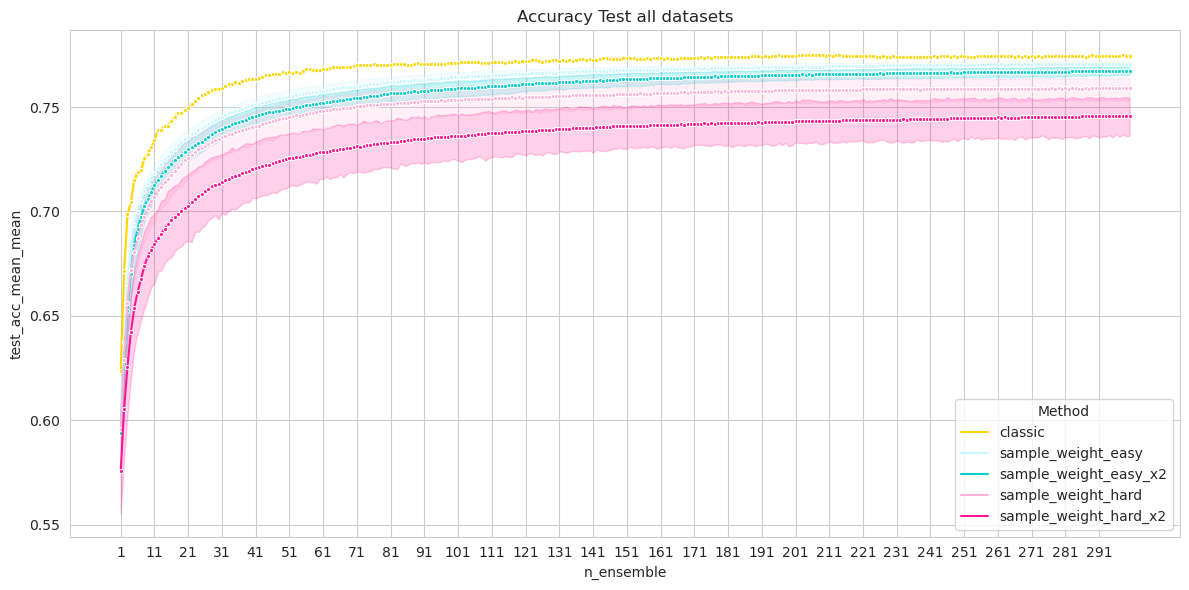

In [13]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=all_gb, x='n_ensemble', y='test_acc_mean_mean', hue='method_weights', errorbar=('ci', 95), marker='.',
             palette=colour_palette_personalized) #  errorbar=(None)

plt.title('Accuracy Test all datasets')
plt.xlabel('n_ensemble')
plt.ylabel('test_acc_mean_mean')
plt.legend(title='Method')
plt.xticks(ticks=range(1, 301, 10)) 
plt.grid(True)
plt.tight_layout()
plt.show()

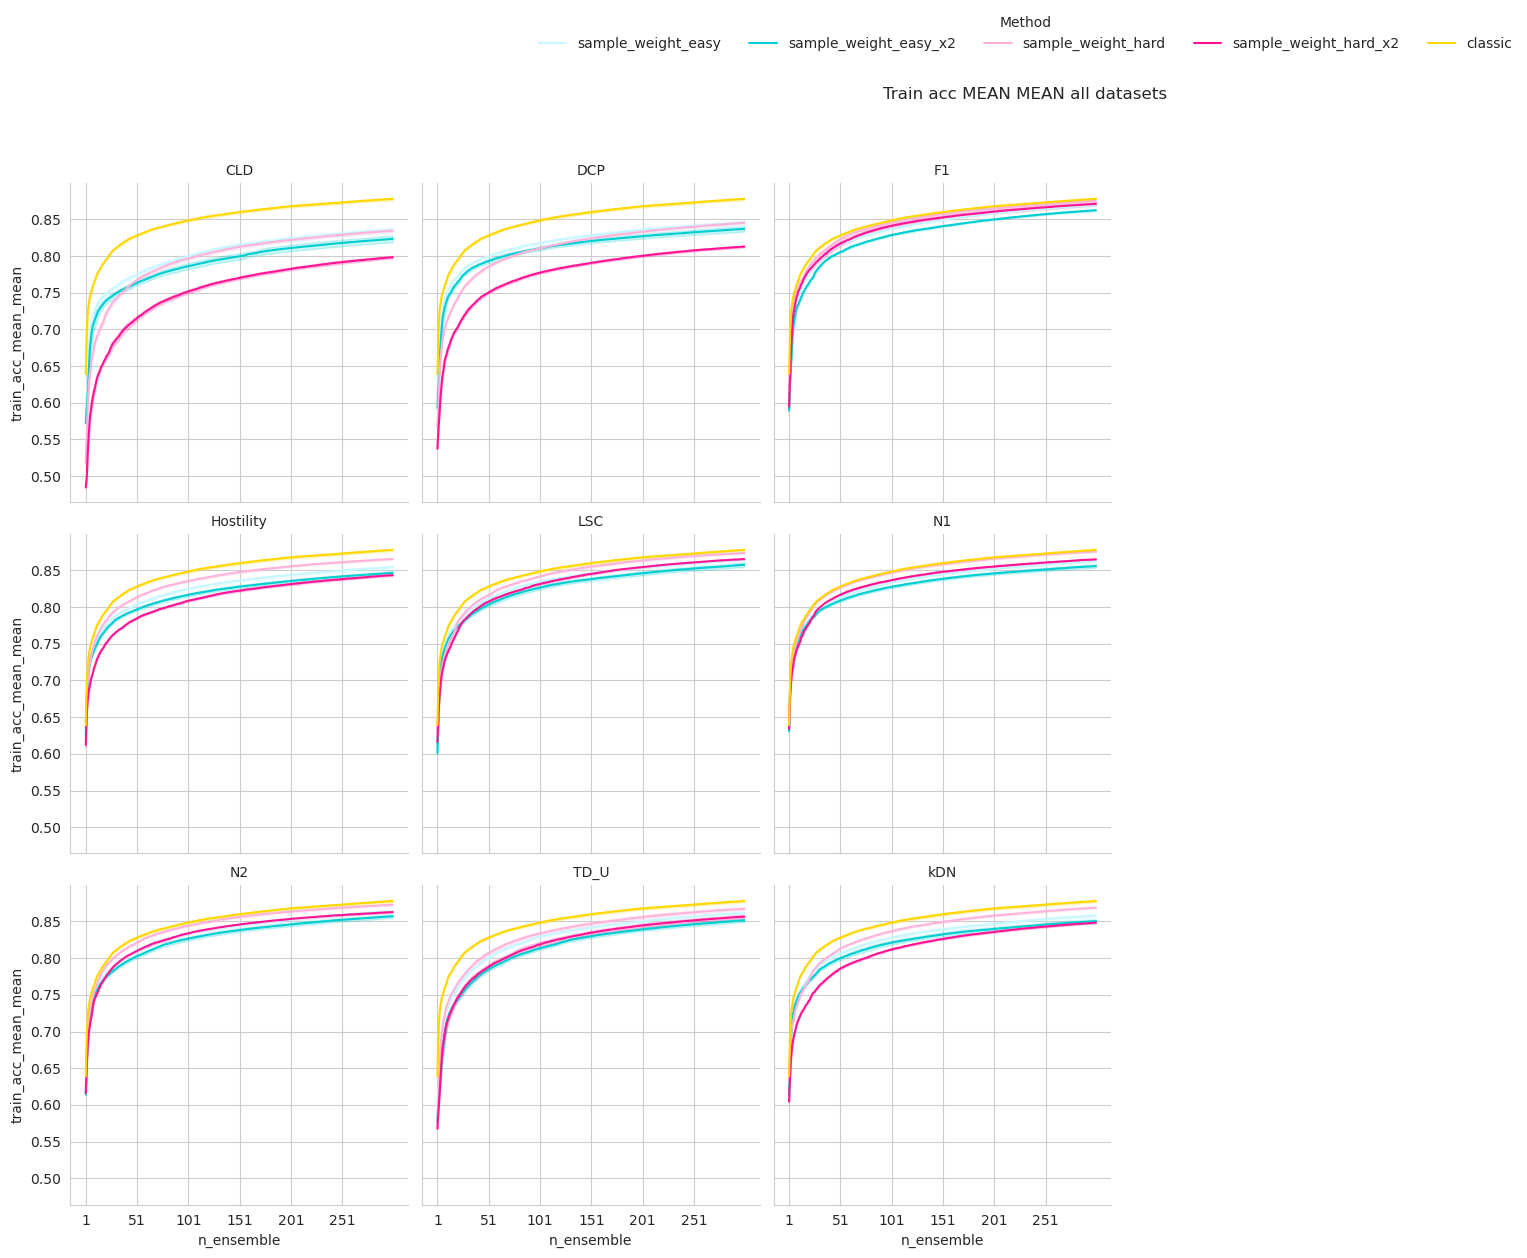

In [14]:
df_complete_all = []

for compl in all_gb[all_gb['method_weights'] != "classic"]['compl_measure'].unique():
    df_subset = all_gb[all_gb['compl_measure'] == compl]

    df_complete_all.append(df_subset)

    classic_data = all_gb[(all_gb['method_weights'] == "classic") & (all_gb['compl_measure'] == "none")].copy()
    classic_data['compl_measure'] = compl
    df_complete_all.append(classic_data)

df_complete_all = pd.concat(df_complete_all)

g = sns.FacetGrid(df_complete_all, col="compl_measure", hue="method_weights", col_wrap=3, height=4, palette=colour_palette_personalized)

g.map(sns.lineplot, 'n_ensemble', 'train_acc_mean_mean')

g.set_titles("{col_name}")
g.set_axis_labels("n_ensemble", "train_acc_mean_mean")
g.add_legend(title="Method", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, frameon=False)

for ax in g.axes.flat:
    ax.set_xticks(range(1, 301, 50))
    ax.grid(True)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Train acc MEAN MEAN all datasets')
plt.show()

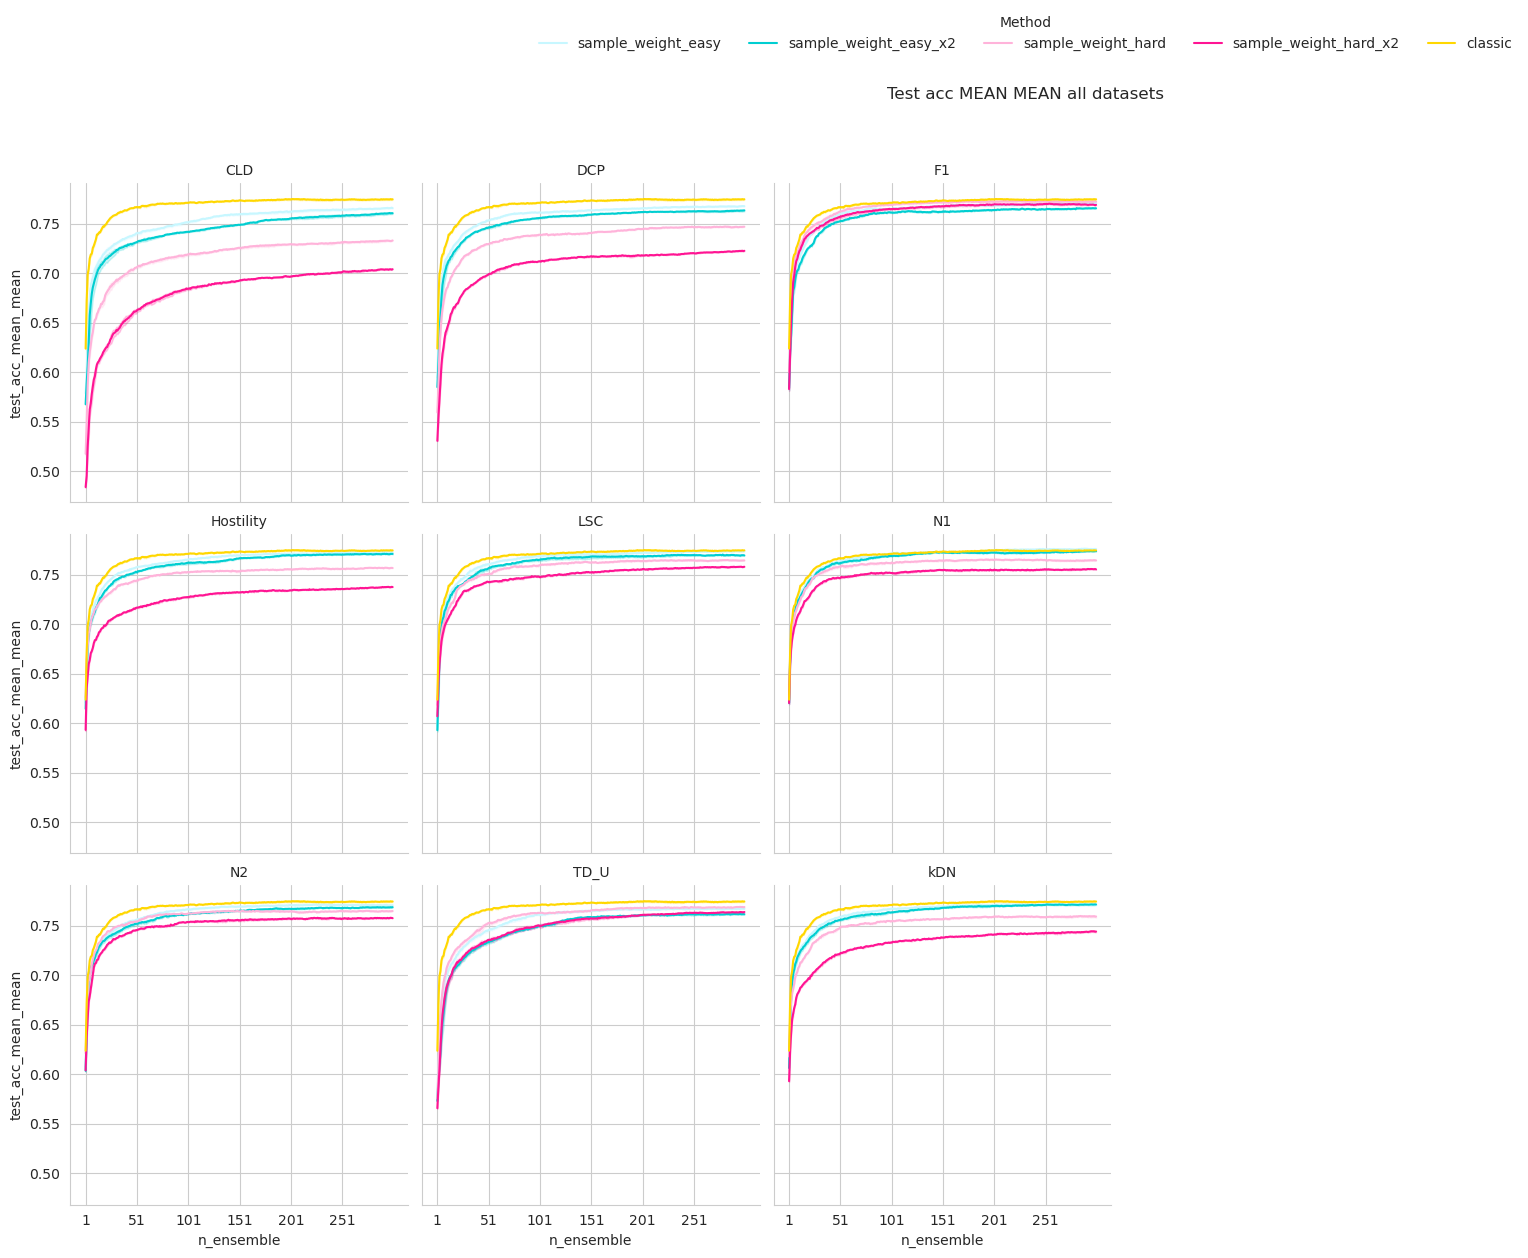

In [15]:
g = sns.FacetGrid(df_complete_all, col="compl_measure", hue="method_weights", col_wrap=3, height=4, palette=colour_palette_personalized)

g.map(sns.lineplot, 'n_ensemble', 'test_acc_mean_mean')

g.set_titles("{col_name}")
g.set_axis_labels("n_ensemble", "test_acc_mean_mean")
g.add_legend(title="Method", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, frameon=False)

for ax in g.axes.flat:
    ax.set_xticks(range(1, 301, 50))
    ax.grid(True)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Test acc MEAN MEAN all datasets')
plt.show()

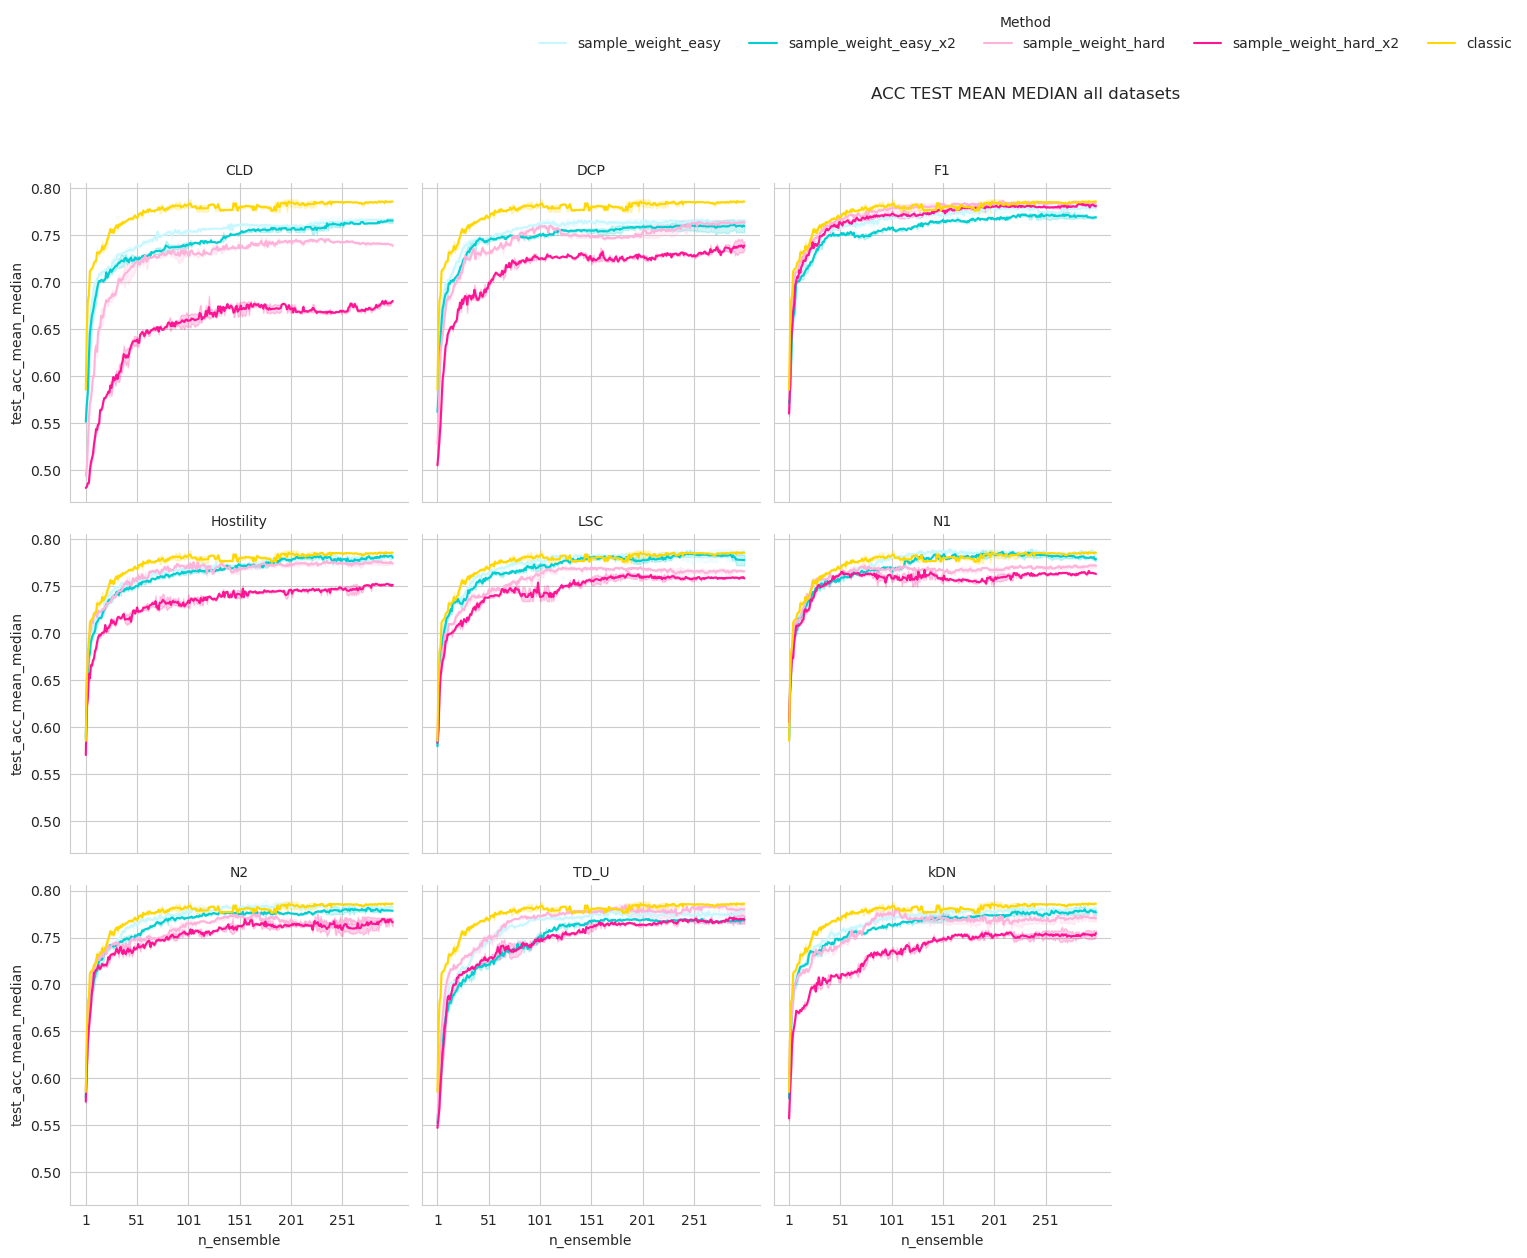

In [16]:
g = sns.FacetGrid(df_complete_all, col="compl_measure", hue="method_weights", col_wrap=3, height=4, palette=colour_palette_personalized)

g.map(sns.lineplot, 'n_ensemble', 'test_acc_mean_median')

g.set_titles("{col_name}")
g.set_axis_labels("n_ensemble", "test_acc_mean_median")
g.add_legend(title="Method", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, frameon=False)

for ax in g.axes.flat:
    ax.set_xticks(range(1, 301, 50))
    ax.grid(True)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('ACC TEST MEAN MEDIAN all datasets')
plt.show()

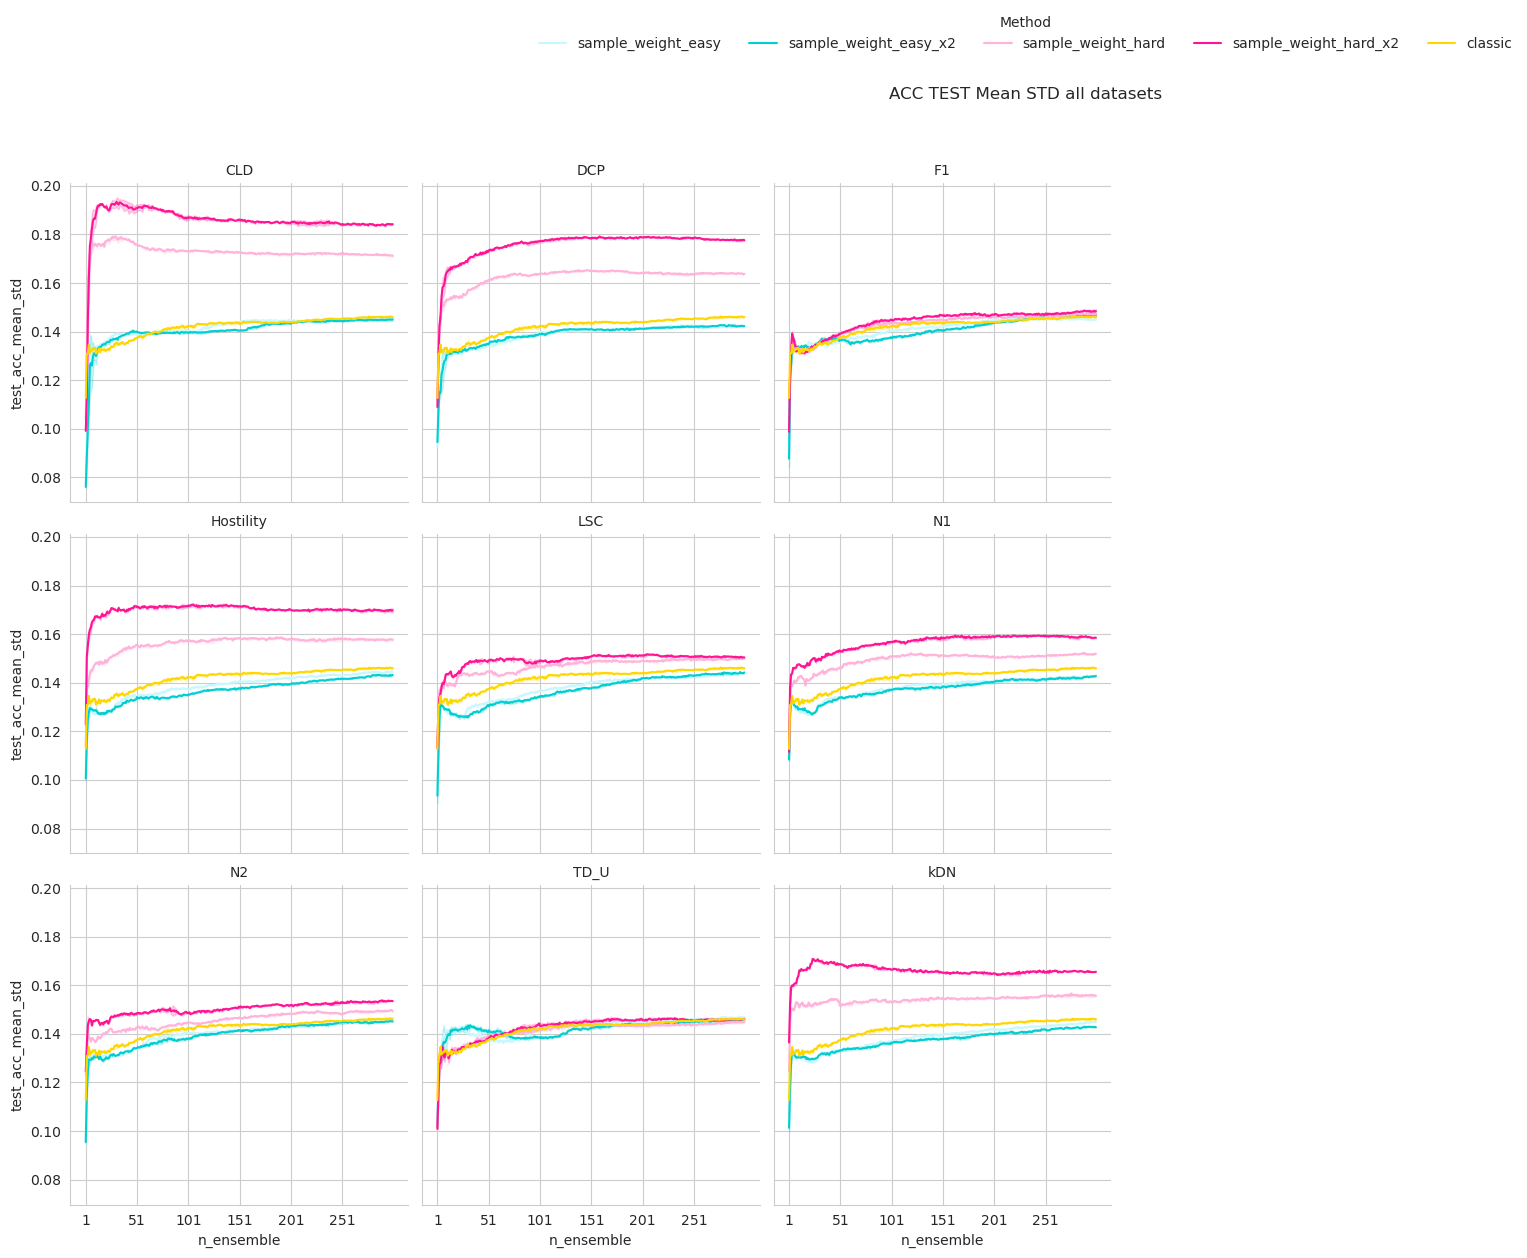

In [17]:
g = sns.FacetGrid(df_complete_all, col="compl_measure", hue="method_weights", col_wrap=3, height=4, palette=colour_palette_personalized)

g.map(sns.lineplot, 'n_ensemble', 'test_acc_mean_std')

g.set_titles("{col_name}")
g.set_axis_labels("n_ensemble", "test_acc_mean_std")
g.add_legend(title="Method", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, frameon=False)

for ax in g.axes.flat:
    ax.set_xticks(range(1, 301, 50))
    ax.grid(True)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('ACC TEST Mean STD all datasets')
plt.show()

In [19]:
# Tabla de mediana, std y media total
summary_results = all_datasets.groupby(['dataset', 'method_weights']).agg(
    test_acc_mean_median=('test_acc_mean', 'median'),
    test_acc_mean_std=('test_acc_mean', 'std'),
    test_acc_mean_total_mean=('test_acc_mean', 'mean')
).reset_index()

# Pivotar para obtener una tabla más organizada
summary_pivot = summary_results.pivot(index='dataset', columns='method_weights', 
                                      values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

# Renombrar columnas para que sean más fáciles de leer
summary_pivot.columns = [f'{method}_{stat}' for stat, method in summary_pivot.columns]
summary_pivot.reset_index(inplace=True)



In [20]:
summary_pivot

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.863768   
1                                   0.709629   
2                                   0.660325   
3                                   0.957143   
4                                   0.806667   
..                                       ...   
107                                 0.952569   
108                                 0.955000   
109                                 0.720000   
110                                 0.770903   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.863768   
1                                      0.709617   
2                                      0.659189   
3                                      0.957143   
4                                      0.806667   
..                                          ...   
107                                    0.950783   
108                                    0.935000   
109                                    0.720000   
110                                    0.766198   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.859420   
1                                   0.702816   
2                                   0.646904   
3                                   0.957143   
4                                   0.773333   
..                                       ...   
107                                 0.956078   
108                                 0.930000   
109                                 0.740000   
110                                 0.772234   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.855072                   0.018492   
1                                      0.688362                   0.010983   
2                                      0.630112                   0.011154   
3                                      0.957143                   0.023066   
4                                      0.746667                   0.028679   
..                                          ...                        ...   
107                                    0.956078                   0.029777   
108                                    0.930000                   0.007970   
109                                    0.720000                   0.027242   
110                                    0.757086                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.023414   
1                                0.018096   
2                                0.023525   
3                                0.038907   
4                                0.039878   
..                                    ...   
107                              0.031482   
108                              0.029917   
109                              0.031894   
110                              0.018606   
111                              0.027714   

     sample_weight_e

We obtain mean, median and std per complexity measure

In [21]:
def summary_CM(CM,dataset):
    all_datasets_CM = dataset.loc[(dataset.compl_measure == CM) | (dataset.compl_measure == 'none'),:]
    summary_results = all_datasets_CM.groupby(['dataset', 'method_weights']).agg(
        test_acc_mean_median=('test_acc_mean', 'median'),
        test_acc_mean_std=('test_acc_mean', 'std'),
        test_acc_mean_total_mean=('test_acc_mean', 'mean')
    ).reset_index()

    # Pivotar para obtener una tabla más organizada
    summary_pivot = summary_results.pivot(index='dataset', columns='method_weights',
                                          values=['test_acc_mean_median', 'test_acc_mean_std', 'test_acc_mean_total_mean'])

    # Renombrar columnas para que sean más fáciles de leer
    summary_pivot.columns = [f'{method}_{stat}' for stat, method in summary_pivot.columns]
    summary_pivot.reset_index(inplace=True)
    return summary_pivot



In [22]:
def plot_summary_CM(CM,summary_table_CM):
    summary_long = summary_table_CM.melt(id_vars='dataset',
                                        value_vars=[
                                            'classic_test_acc_mean_median',
                                            'sample_weight_easy_test_acc_mean_median',
                                            'sample_weight_easy_x2_test_acc_mean_median',
                                            'sample_weight_hard_test_acc_mean_median',
                                            'sample_weight_hard_x2_test_acc_mean_median',
                                            'classic_test_acc_mean_std',
                                            'sample_weight_easy_test_acc_mean_std',
                                            'sample_weight_easy_x2_test_acc_mean_std',
                                            'sample_weight_hard_test_acc_mean_std',
                                            'sample_weight_hard_x2_test_acc_mean_std',
                                             'classic_test_acc_mean_total_mean',
                                            'sample_weight_easy_test_acc_mean_total_mean',
                                            'sample_weight_easy_x2_test_acc_mean_total_mean',
                                            'sample_weight_hard_test_acc_mean_total_mean',
                                            'sample_weight_hard_x2_test_acc_mean_total_mean',
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long[['method', 'statistic']] = summary_long['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long['method'] = summary_long['method'].replace({
        'classic_test_acc_mean': 'Classic',
        'sample_weight_easy_test_acc_mean': 'Easy',
        'sample_weight_easy_x2_test_acc_mean': 'Easy x2',
        'sample_weight_hard_test_acc_mean': 'Hard',
        'sample_weight_hard_x2_test_acc_mean': 'Hard x2',
        'classic_test_acc_mean_total': 'Classic',
        'sample_weight_easy_test_acc_mean_total': 'Easy',
        'sample_weight_easy_x2_test_acc_mean_total': 'Easy x2',
        'sample_weight_hard_test_acc_mean_total': 'Hard',
        'sample_weight_hard_x2_test_acc_mean_total': 'Hard x2',
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(14, 6))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long[summary_long['statistic'] == stat],
                     x='method',
                     y='value',
                     palette='Set2')

        #plt.title(f'Boxplot of {stat.replace("mean_", "").replace("total_", "Total ").capitalize()}')
        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())
        plt.xticks(rotation=90)

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()
    return

#### Summary table with Hostility

In [30]:
CM = 'Hostility'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_Hostility.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.862319   
1                                   0.720246   
2                                   0.668177   
3                                   0.957143   
4                                   0.826667   
..                                       ...   
107                                 0.954292   
108                                 0.955000   
109                                 0.720000   
110                                 0.770227   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.862319   
1                                      0.720241   
2                                      0.667004   
3                                      0.957143   
4                                      0.790000   
..                                          ...   
107                                    0.950815   
108                                    0.930000   
109                                    0.720000   
110                                    0.765522   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.859420   
1                                   0.677015   
2                                   0.638976   
3                                   0.957143   
4                                   0.786667   
..                                       ...   
107                                 0.954323   
108                                 0.930000   
109                                 0.780000   
110                                 0.780333   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.857971                   0.018492   
1                                      0.596721                   0.010983   
2                                      0.544794                   0.011154   
3                                      0.971429                   0.023066   
4                                      0.766667                   0.028679   
..                                          ...                        ...   
107                                    0.961372                   0.029777   
108                                    0.930000                   0.007970   
109                                    0.740000                   0.027242   
110                                    0.753378                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.018478   
1                                0.015132   
2                                0.012161   
3                                0.024012   
4                                0.031650   
..                                    ...   
107                              0.028035   
108                              0.013283   
109                              0.017141   
110                              0.015594   
111                              0.023154   

     sample_weight_e

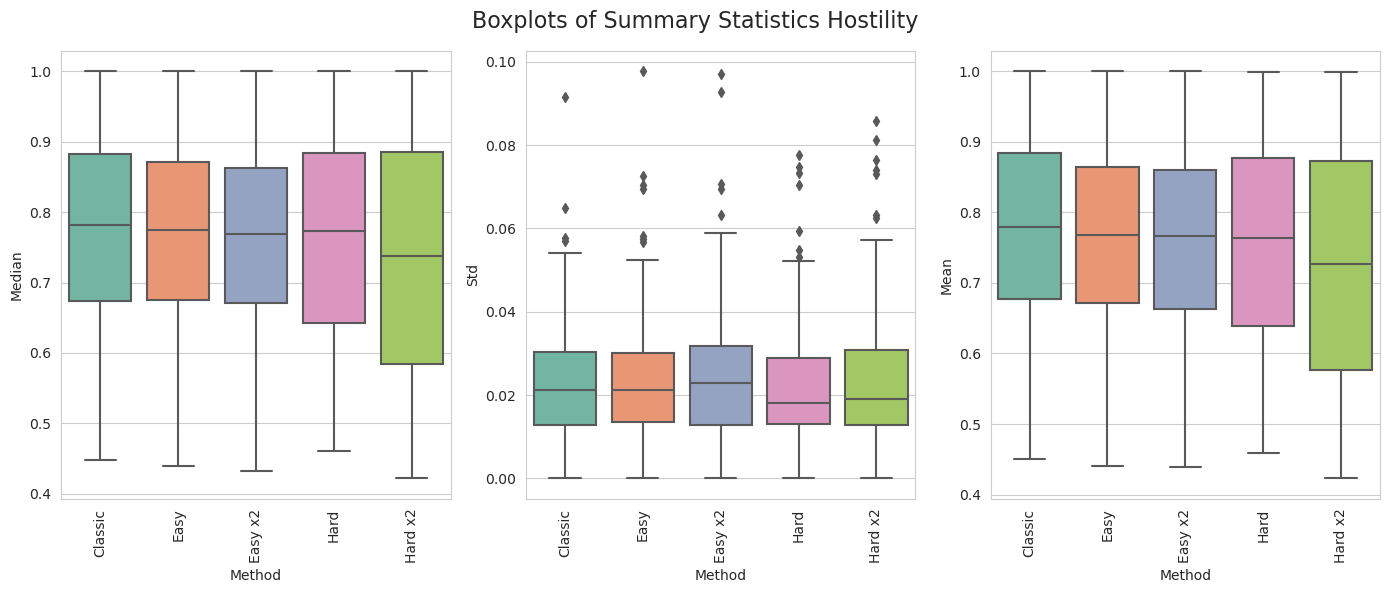

In [31]:
plot_summary_CM(CM,summary_table_CM)

#### Summary table with kDN

In [32]:
CM = 'kDN'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_kDN.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.863768   
1                                   0.716441   
2                                   0.662597   
3                                   0.957143   
4                                   0.766667   
..                                       ...   
107                                 0.952538   
108                                 0.955000   
109                                 0.720000   
110                                 0.770241   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.863768   
1                                      0.719480   
2                                      0.659819   
3                                      0.957143   
4                                      0.766667   
..                                          ...   
107                                    0.954292   
108                                    0.935000   
109                                    0.720000   
110                                    0.764201   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.860870   
1                                   0.702030   
2                                   0.642441   
3                                   0.957143   
4                                   0.786667   
..                                       ...   
107                                 0.961341   
108                                 0.910000   
109                                 0.760000   
110                                 0.771531   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.850725                   0.018492   
1                                      0.667927                   0.010983   
2                                      0.551586                   0.011154   
3                                      0.971429                   0.023066   
4                                      0.786667                   0.028679   
..                                          ...                        ...   
107                                    0.961341                   0.029777   
108                                    0.930000                   0.007970   
109                                    0.720000                   0.027242   
110                                    0.750689                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.023724   
1                                0.011537   
2                                0.012619   
3                                0.034720   
4                                0.029425   
..                                    ...   
107                              0.031328   
108                              0.026251   
109                              0.016847   
110                              0.014872   
111                              0.028622   

     sample_weight_e

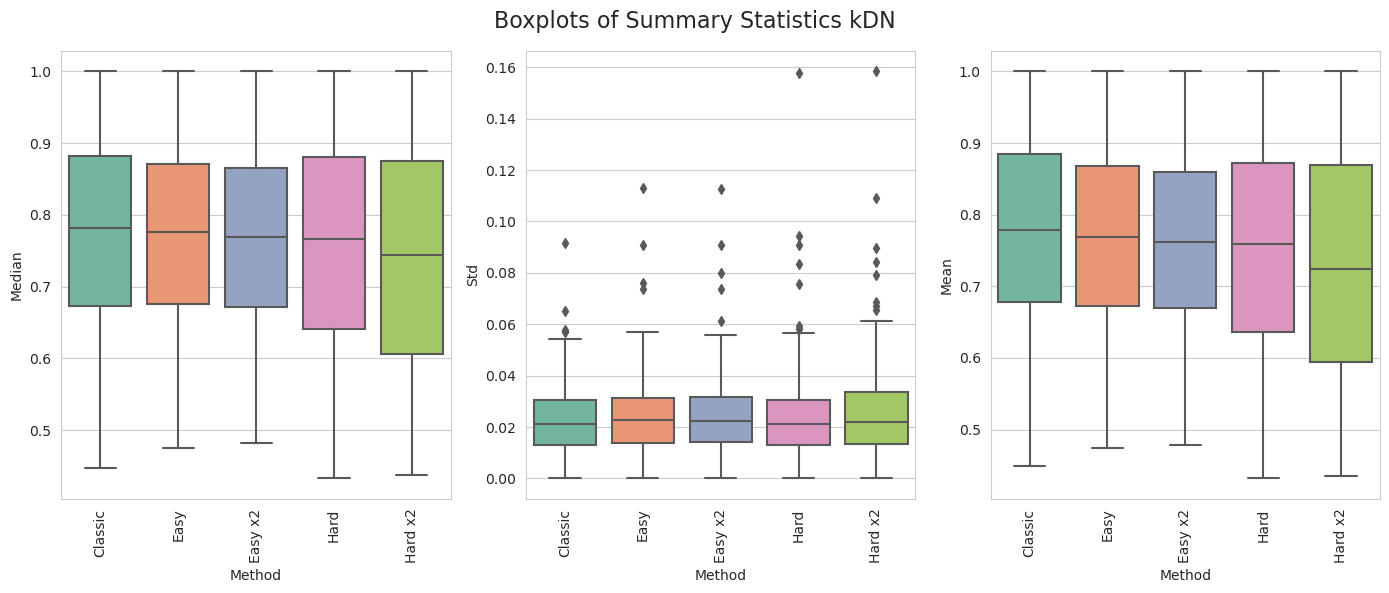

In [33]:
plot_summary_CM(CM,summary_table_CM)

#### Summary table with N1

In [34]:
CM = 'N1'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_N1.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.868116   
1                                   0.711896   
2                                   0.662497   
3                                   0.971429   
4                                   0.826667   
..                                       ...   
107                                 0.957832   
108                                 0.955000   
109                                 0.700000   
110                                 0.778333   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.865217   
1                                      0.712659   
2                                      0.661348   
3                                      0.971429   
4                                      0.803333   
..                                          ...   
107                                    0.957832   
108                                    0.955000   
109                                    0.700000   
110                                    0.775635   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.863768   
1                                   0.708096   
2                                   0.663770   
3                                   0.957143   
4                                   0.766667   
..                                       ...   
107                                 0.959618   
108                                 0.910000   
109                                 0.720000   
110                                 0.781671   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.860870                   0.018492   
1                                      0.694448                   0.010983   
2                                      0.633458                   0.011154   
3                                      0.957143                   0.023066   
4                                      0.726667                   0.028679   
..                                          ...                        ...   
107                                    0.959586                   0.029777   
108                                    0.930000                   0.007970   
109                                    0.740000                   0.027242   
110                                    0.776274                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.020892   
1                                0.009504   
2                                0.009172   
3                                0.023367   
4                                0.034842   
..                                    ...   
107                              0.029571   
108                              0.008488   
109                              0.033665   
110                              0.017757   
111                              0.023459   

     sample_weight_e

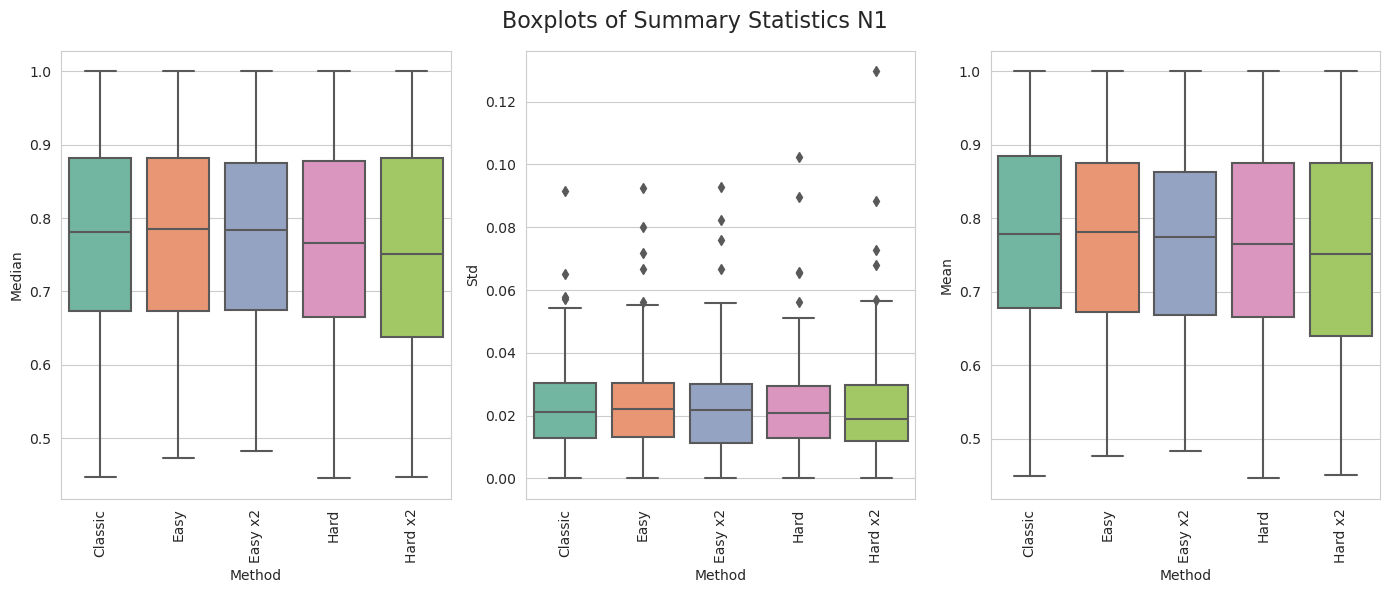

In [35]:
plot_summary_CM(CM,summary_table_CM)

#### Summary table with N2

In [36]:
CM = 'N2'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_N2.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.862319   
1                                   0.705806   
2                                   0.659189   
3                                   0.957143   
4                                   0.806667   
..                                       ...   
107                                 0.952538   
108                                 0.955000   
109                                 0.720000   
110                                 0.776986   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.863768   
1                                      0.704285   
2                                      0.659757   
3                                      0.957143   
4                                      0.823333   
..                                          ...   
107                                    0.947274   
108                                    0.930000   
109                                    0.720000   
110                                    0.774288   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.868116   
1                                   0.719477   
2                                   0.661448   
3                                   0.957143   
4                                   0.746667   
..                                       ...   
107                                 0.961341   
108                                 0.930000   
109                                 0.720000   
110                                 0.781671   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.860870                   0.018492   
1                                      0.713393                   0.010983   
2                                      0.653602                   0.011154   
3                                      0.957143                   0.023066   
4                                      0.766667                   0.028679   
..                                          ...                        ...   
107                                    0.959618                   0.029777   
108                                    0.930000                   0.007970   
109                                    0.760000                   0.027242   
110                                    0.778972                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.025444   
1                                0.011052   
2                                0.011569   
3                                0.035577   
4                                0.040149   
..                                    ...   
107                              0.028272   
108                              0.023466   
109                              0.027418   
110                              0.017914   
111                              0.011797   

     sample_weight_e

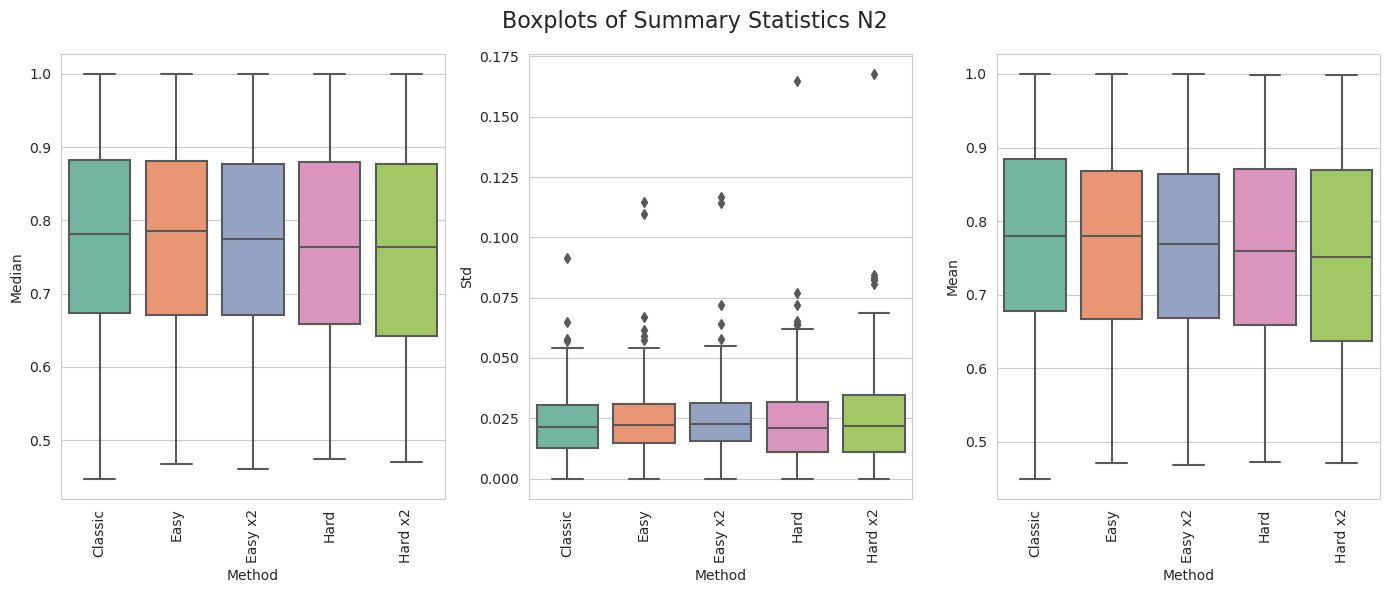

In [37]:
plot_summary_CM(CM,summary_table_CM)

#### Summary table with DCP

In [38]:
CM = 'DCP'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_DCP.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.860870   
1                                   0.674717   
2                                   0.650200   
3                                   0.971429   
4                                   0.786667   
..                                       ...   
107                                 0.952600   
108                                 0.955000   
109                                 0.720000   
110                                 0.764820   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.857971   
1                                      0.668656   
2                                      0.645718   
3                                      0.971429   
4                                      0.766667   
..                                          ...   
107                                    0.952600   
108                                    0.935000   
109                                    0.680000   
110                                    0.756077   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.840580   
1                                   0.580381   
2                                   0.531411   
3                                   0.957143   
4                                   0.766667   
..                                       ...   
107                                 0.950752   
108                                 0.955000   
109                                 0.680000   
110                                 0.750667   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.784058                   0.018492   
1                                      0.511017                   0.010983   
2                                      0.467016                   0.011154   
3                                      0.957143                   0.023066   
4                                      0.746667                   0.028679   
..                                          ...                        ...   
107                                    0.945520                   0.029777   
108                                    0.955000                   0.007970   
109                                    0.680000                   0.027242   
110                                    0.632047                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.030941   
1                                0.011997   
2                                0.010135   
3                                0.047301   
4                                0.037689   
..                                    ...   
107                              0.024035   
108                              0.016224   
109                              0.035332   
110                              0.014701   
111                              0.023459   

     sample_weight_e

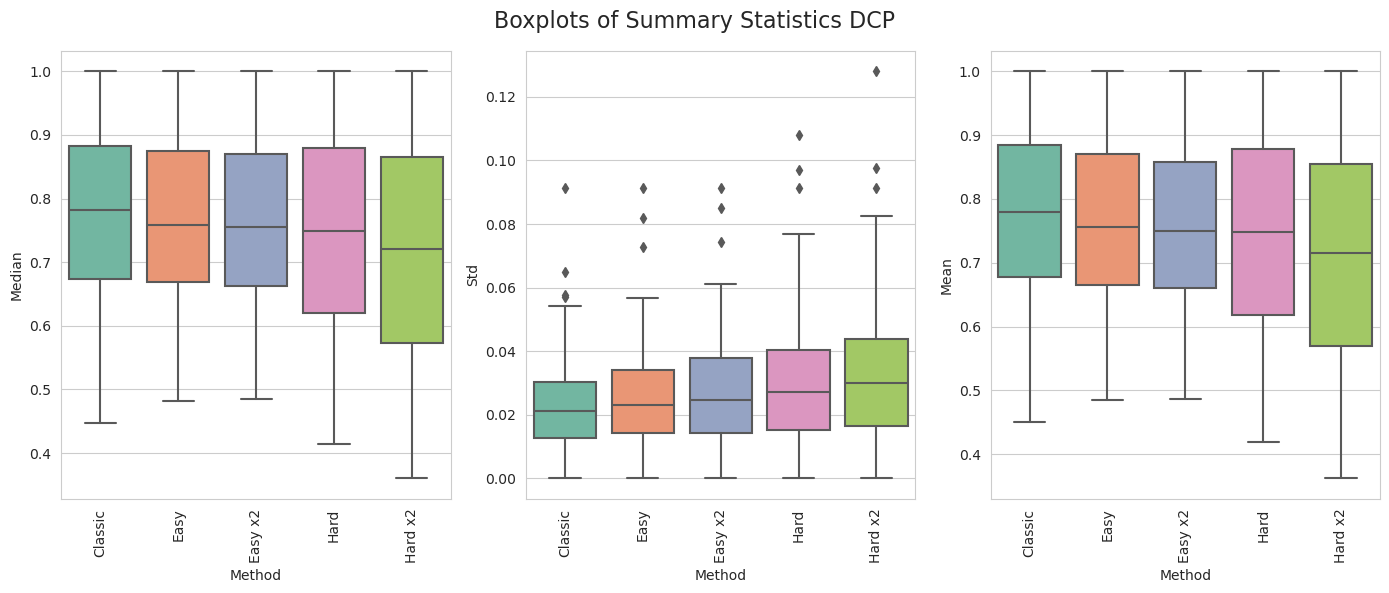

In [39]:
plot_summary_CM(CM,summary_table_CM)

#### Summary table with LSC

In [40]:
CM = 'LSC'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_LSC.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.863768   
1                                   0.710381   
2                                   0.660312   
3                                   0.957143   
4                                   0.826667   
..                                       ...   
107                                 0.950752   
108                                 0.955000   
109                                 0.740000   
110                                 0.778319   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.865217   
1                                      0.708860   
2                                      0.659164   
3                                      0.957143   
4                                      0.826667   
..                                          ...   
107                                    0.943703   
108                                    0.955000   
109                                    0.740000   
110                                    0.778365   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.860870   
1                                   0.722519   
2                                   0.668190   
3                                   0.957143   
4                                   0.746667   
..                                       ...   
107                                 0.959586   
108                                 0.930000   
109                                 0.740000   
110                                 0.769545   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.856522                   0.018492   
1                                      0.707321                   0.010983   
2                                      0.655843                   0.011154   
3                                      0.957143                   0.023066   
4                                      0.746667                   0.028679   
..                                          ...                        ...   
107                                    0.959618                   0.029777   
108                                    0.885000                   0.007970   
109                                    0.720000                   0.027242   
110                                    0.766849                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.021329   
1                                0.009008   
2                                0.007419   
3                                0.035792   
4                                0.041346   
..                                    ...   
107                              0.021725   
108                              0.028096   
109                              0.034998   
110                              0.016385   
111                              0.037282   

     sample_weight_e

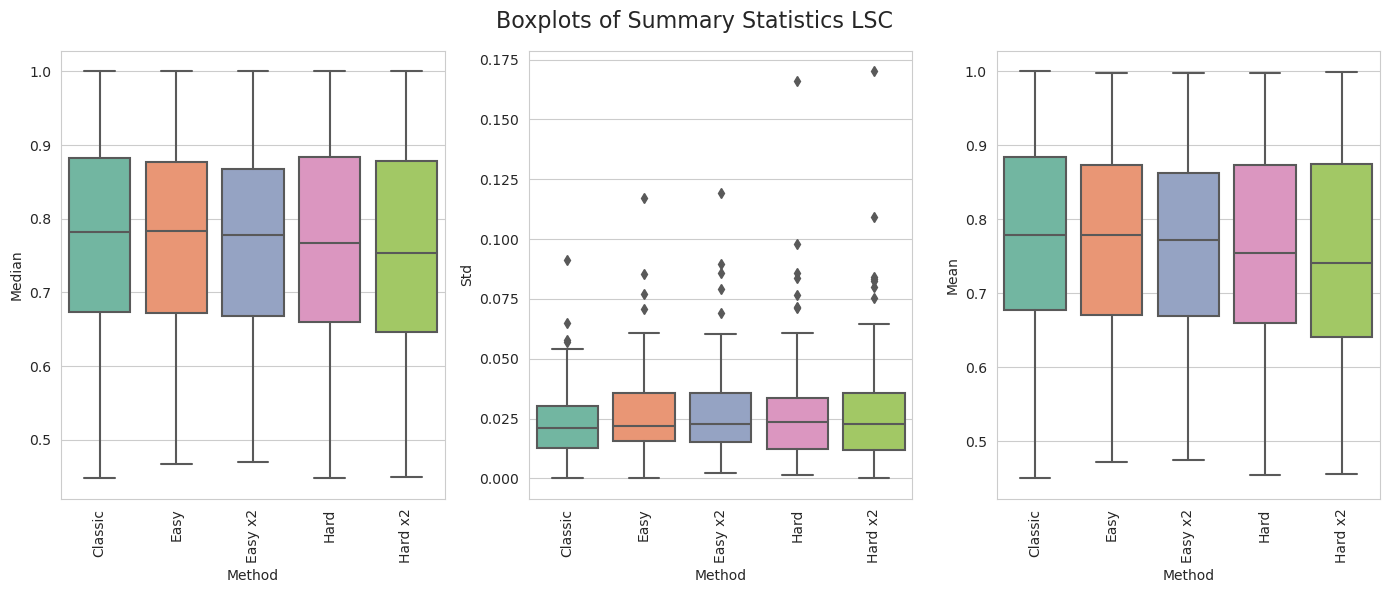

In [41]:
plot_summary_CM(CM,summary_table_CM)

#### Summary table with F1

In [42]:
CM = 'F1'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_F1.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.866667   
1                                   0.709623   
2                                   0.669213   
3                                   0.957143   
4                                   0.810000   
..                                       ...   
107                                 0.952538   
108                                 0.930000   
109                                 0.740000   
110                                 0.775619   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.863768   
1                                      0.714157   
2                                      0.668090   
3                                      0.957143   
4                                      0.826667   
..                                          ...   
107                                    0.950752   
108                                    0.870000   
109                                    0.740000   
110                                    0.772928   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.862319   
1                                   0.712630   
2                                   0.658015   
3                                   0.957143   
4                                   0.826667   
..                                       ...   
107                                 0.961372   
108                                 0.955000   
109                                 0.720000   
110                                 0.780346   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.860870                   0.018492   
1                                      0.711867                   0.010983   
2                                      0.658015                   0.011154   
3                                      0.957143                   0.023066   
4                                      0.826667                   0.028679   
..                                          ...                        ...   
107                                    0.961372                   0.029777   
108                                    0.955000                   0.007970   
109                                    0.760000                   0.027242   
110                                    0.780342                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.033119   
1                                0.011722   
2                                0.012043   
3                                0.037659   
4                                0.015714   
..                                    ...   
107                              0.021100   
108                              0.046690   
109                              0.028362   
110                              0.018173   
111                              0.013057   

     sample_weight_e

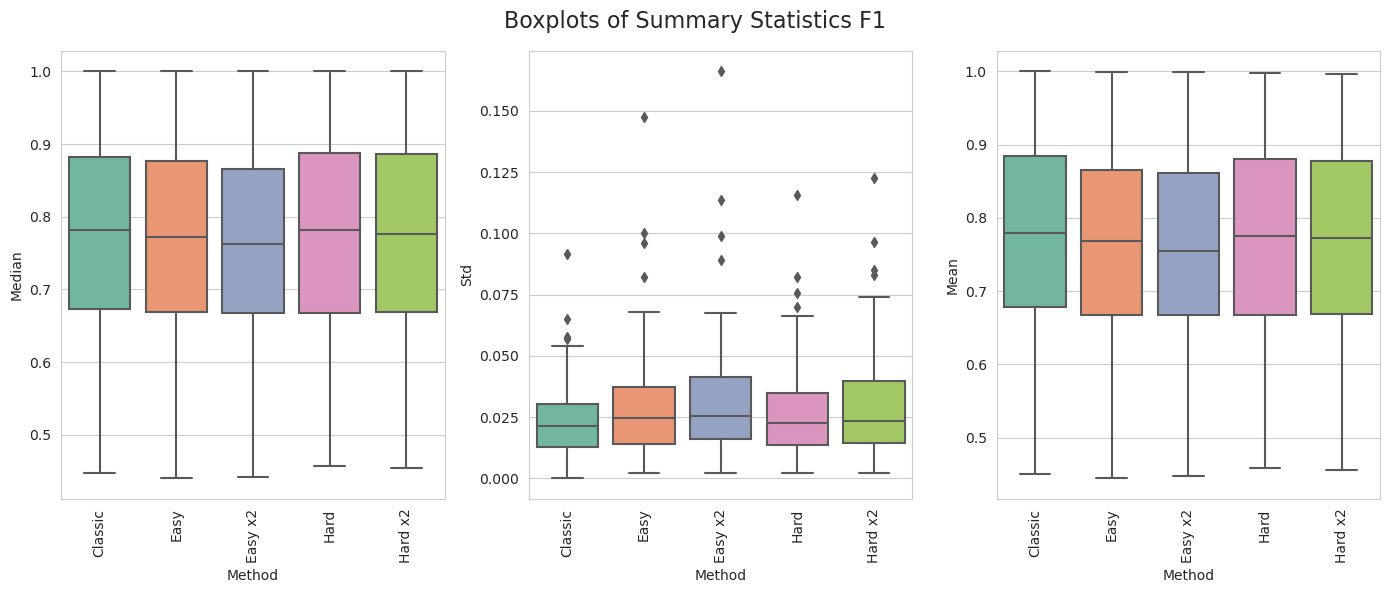

In [43]:
plot_summary_CM(CM,summary_table_CM)

#### Summary table with TD_U

In [44]:
CM = 'TD_U'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_TDU.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.863768   
1                                   0.724023   
2                                   0.665918   
3                                   0.971429   
4                                   0.823333   
..                                       ...   
107                                 0.968390   
108                                 0.955000   
109                                 0.720000   
110                                 0.773562   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.862319   
1                                      0.715655   
2                                      0.662534   
3                                      0.971429   
4                                      0.823333   
..                                          ...   
107                                    0.968390   
108                                    0.955000   
109                                    0.700000   
110                                    0.766833   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.857971   
1                                   0.705063   
2                                   0.645780   
3                                   0.957143   
4                                   0.786667   
..                                       ...   
107                                 0.948997   
108                                 0.910000   
109                                 0.700000   
110                                 0.778995   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.850725                   0.018492   
1                                      0.704308                   0.010983   
2                                      0.636804                   0.011154   
3                                      0.957143                   0.023066   
4                                      0.746667                   0.028679   
..                                          ...                        ...   
107                                    0.945489                   0.029777   
108                                    0.885000                   0.007970   
109                                    0.700000                   0.027242   
110                                    0.776301                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.019018   
1                                0.020921   
2                                0.008144   
3                                0.052267   
4                                0.046753   
..                                    ...   
107                              0.037540   
108                              0.021727   
109                              0.024912   
110                              0.018035   
111                              0.023459   

     sample_weight_e

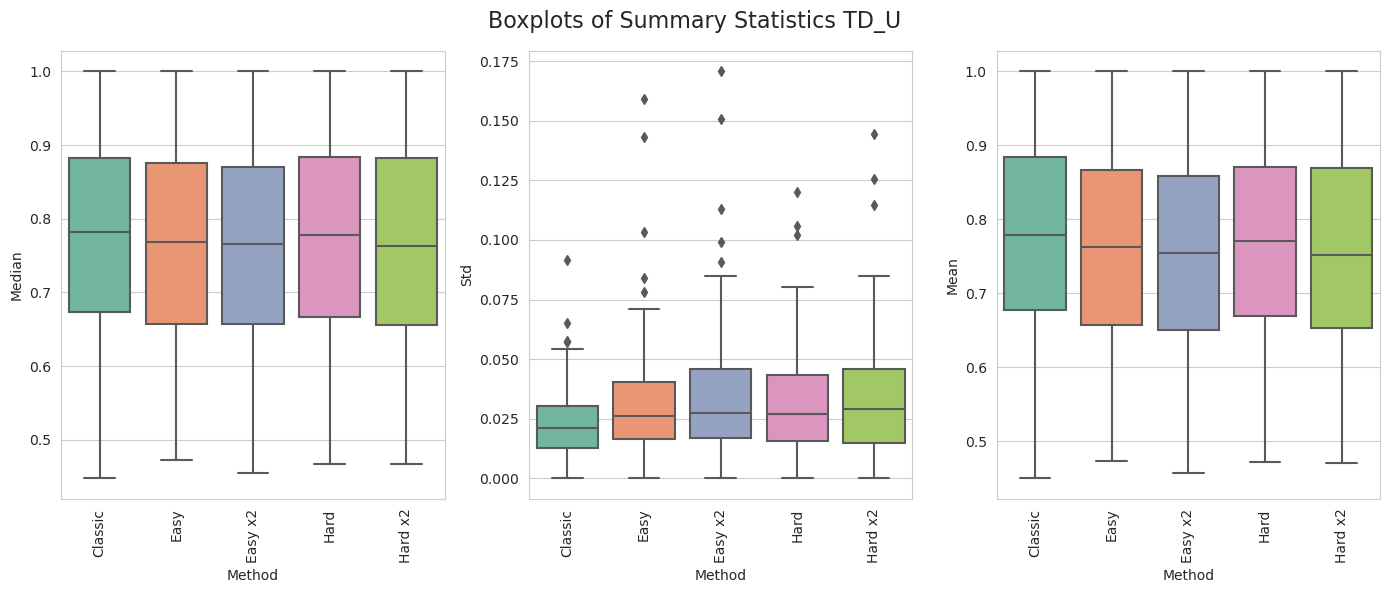

In [45]:
plot_summary_CM(CM,summary_table_CM)

#### Summary table with CLD

In [46]:
CM = 'CLD'
summary_table_CM = summary_CM(CM,all_datasets)
summary_table_CM
#summary_table_CM.to_csv('SummaryStatistics_PerDataset_Boosting_CLD.csv')

dataset  classic_test_acc_mean_median  \
0                  Australian                      0.865217   
1         WineQualityRed_5vs6                      0.714920   
2              Yeast_CYTvsNUC                      0.672634   
3       analcatdata_gviolence                      0.957143   
4    analcatdata_japansolvent                      0.766667   
..                        ...                           ...   
107                      wdbc                      0.959586   
108         wind_correlations                      0.955000   
109        witmer_census_1980                      0.740000   
110                    yeast1                      0.778972   
111                       zoo                      1.000000   

     sample_weight_easy_test_acc_mean_median  \
0                                   0.866667   
1                                   0.708114   
2                                   0.600874   
3                                   0.957143   
4                                   0.806667   
..                                       ...   
107                                 0.950783   
108                                 0.955000   
109                                 0.740000   
110                                 0.742615   
111                                 1.000000   

     sample_weight_easy_x2_test_acc_mean_median  \
0                                      0.866667   
1                                      0.703545   
2                                      0.582928   
3                                      0.957143   
4                                      0.786667   
..                                          ...   
107                                    0.938471   
108                                    0.955000   
109                                    0.740000   
110                                    0.737230   
111                                    1.000000   

     sample_weight_hard_test_acc_mean_median  \
0                                   0.834783   
1                                   0.589839   
2                                   0.513458   
3                                   0.957143   
4                                   0.706667   
..                                       ...   
107                                 0.956078   
108                                 0.890000   
109                                 0.760000   
110                                 0.745969   
111                                 1.000000   

     sample_weight_hard_x2_test_acc_mean_median  classic_test_acc_mean_std  \
0                                      0.760870                   0.018492   
1                                      0.488226                   0.010983   
2                                      0.504494                   0.011154   
3                                      0.957143                   0.023066   
4                                      0.726667                   0.028679   
..                                          ...                        ...   
107                                    0.950815                   0.029777   
108                                    0.890000                   0.007970   
109                                    0.720000                   0.027242   
110                                    0.652286                   0.018823   
111                                    1.000000                   0.023459   

     sample_weight_easy_test_acc_mean_std  \
0                                0.006546   
1                                0.013931   
2                                0.018135   
3                                0.045118   
4                                0.024398   
..                                    ...   
107                              0.047405   
108                              0.047637   
109                              0.024793   
110                              0.010479   
111                              0.046975   

     sample_weight_e

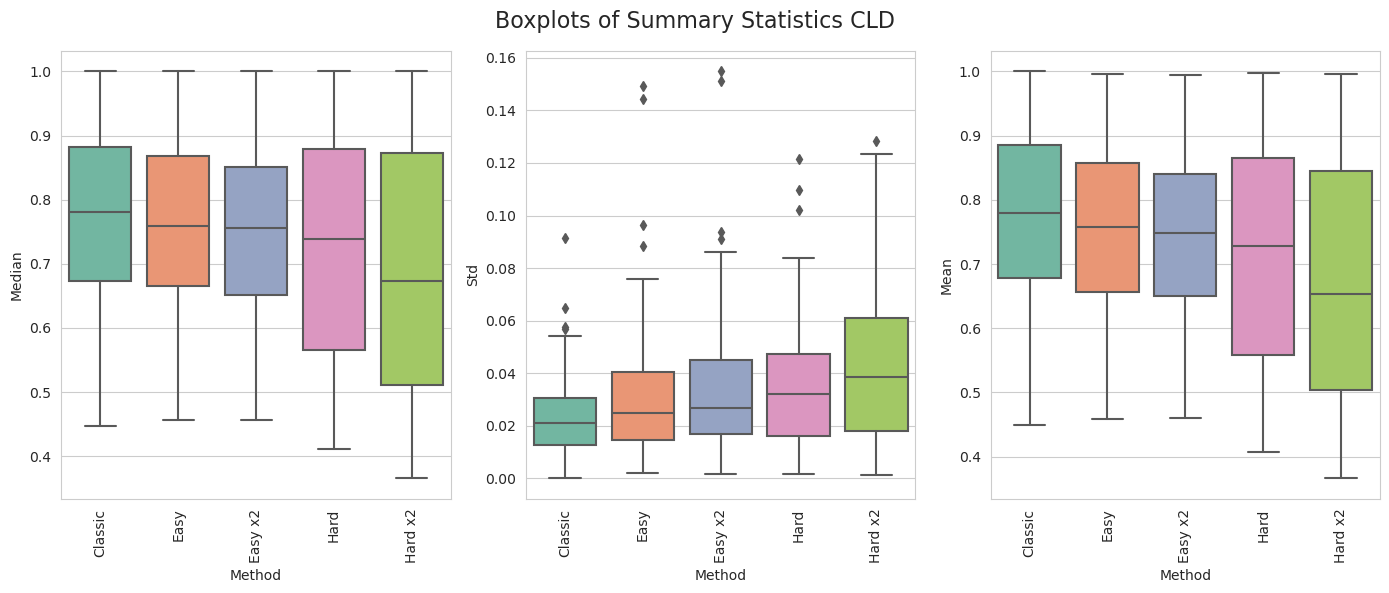

In [47]:
plot_summary_CM(CM,summary_table_CM)

In [48]:
all_datasets.head()

dataset  n_ensemble method_weights compl_measure  \
0  analcatdata_gviolence           1        classic          none   
1  analcatdata_gviolence           2        classic          none   
2  analcatdata_gviolence           3        classic          none   
3  analcatdata_gviolence           4        classic          none   
4  analcatdata_gviolence           5        classic          none   

  loss_selected  loss_train_mean  loss_test_mean  train_acc_mean  \
0      log_loss         0.594795        0.595964        0.581072   
1      log_loss         0.525625        0.527052        0.972953   
2      log_loss         0.468327        0.470040        0.972953   
3      log_loss         0.420207        0.422230        0.972953   
4      log_loss         0.379347        0.384646        0.972953   

   test_acc_mean  loss_train_std  loss_test_std  train_acc_std  test_acc_std  \
0       0.580357        0.002832       0.014582       0.004567      0.037881   
1       0.971429        0.004412       0.020456       0.006392      0.060234   
2       0.971429        0.005802       0.027505       0.006392      0.060234   
3       0.971429        0.007018       0.034744       0.006392      0.060234   
4       0.971429        0.008074       0.040833       0.006392      0.060234   

   conf_matr_train_total conf_matr_test_total  
0   [[387, 0], [279, 0]]   [[43, 0], [31, 0]]  
1  [[369, 18], [0, 279]]   [[41, 2], [0, 31]]  
2  [[369, 18], [0, 279]]   [[41, 2], [0, 31]]  
3  [[369, 18], [0, 279]]   [[41, 2], [0, 31]]  
4  [[369, 18], [0, 279]]   [[41, 2], [0, 31]]

#### Graph analysis per complexity measure and per dataset

In [49]:
def plot_per_CM_dataset(CM,dataset):
    # Grid dimensiones
    num_datasets = dataset['dataset'].nunique()
    num_cols = 4  # Ajusta esto según el diseño que prefieras
    num_rows = math.ceil(num_datasets / num_cols)

    # Configura el tamaño de la figura
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), sharex=True, sharey=False)
    fig.suptitle('Test acc across Datasets for: '+CM, fontsize=18)

    all_datasets_CM = dataset.loc[(dataset['compl_measure'] == CM) | (dataset['compl_measure'] == 'none'),:]

    # Itera sobre cada dataset y subtrama correspondiente
    for i, (name_dataset, data) in enumerate(all_datasets_CM.groupby('dataset')):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]  # Selecciona el subplot correspondiente

        # Crear el gráfico de líneas para el dataset actual
        sns.lineplot(data=data, x='n_ensemble', y='test_acc_mean', hue='method_weights',
                     #marker='.',
                     palette=colour_palette_personalized, ax=ax, legend=False)

        # Configuración de cada subplot
        ax.set_title(f'{name_dataset}')
        #ax.set_xlabel('n_ensemble')
        #ax.set_ylabel('misc_rate_test_mean')
        ax.set_xticks(range(1, 301, 50))
        ax.grid(True)

    # Agrega una leyenda global fuera de la cuadrícula de gráficos
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title='Method', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=12)
    # 
    # # add legend
    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(0.8, 1), frameon=False)


    # Ajusta el diseño para que no se superpongan las gráficas y la leyenda global
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Ajusta para dejar espacio para el título y la leyenda
    plt.show()
    return

In [50]:
# Reordenamos para que al pintar siempre se pinte el último el métod classic y facilite la comparación
all_datasets_reordenada = pd.concat([
    all_datasets[all_datasets['method_weights'] != 'classic'],  
    all_datasets[all_datasets['method_weights'] == 'classic']   
])

We have a lot of datasets, so we cannot visualize the results for all of them for all complexity measures in one notebook (it will be too heavy). So, we will focus on win-tie-loss analyses.

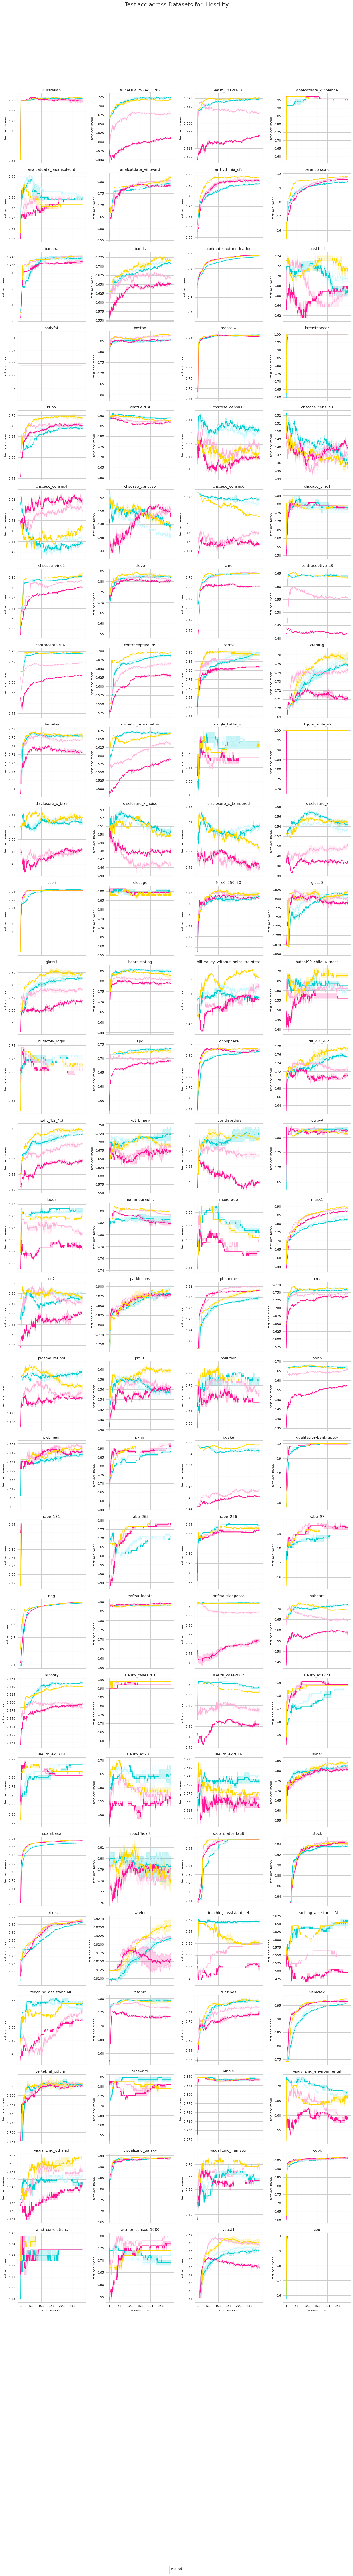

In [51]:
CM = 'Hostility'
plot_per_CM_dataset(CM,all_datasets_reordenada)

### WTL Analysis per complexity measure and method

In [52]:

def win_tie_loss_comparison(data, main_method, compare_method,loss_function,
                            metric='test_acc_mean',  n_ensemble_values=[10, 25, 50, 100, 150, 200, 250, 300]):
    """
    Realiza un análisis win-tie-loss comparando el método principal con otro método específico para cada medida de complejidad.

    Parameters:
    - data: DataFrame con las columnas ['dataset', 'n_ensemble', 'method_weights', 'compl_measure', metric]
    - main_method: método principal que se desea comparar (ejemplo: 'classic')
    - compare_method: método específico con el cual comparar el principal (ejemplo: 'init_easy')
    - metric: métrica de comparación (por defecto 'misc_rate_test_mean')
    - n_ensemble_values: valores de n_ensemble a considerar

    Returns:
    - Una tabla con el conteo de wins, ties, y losses por cada valor de n_ensemble y medida de complejidad.
    """
    results = []

    for n in n_ensemble_values:
        # Filtrar los datos para el valor actual de n_ensemble
        subset_n = data[(data['n_ensemble'] == n) & (data['loss_selected'] == loss_function)]


        # Crear un diccionario para almacenar los resultados de esta combinación de n_ensemble
        row = {'n_ensemble': n}

        CM_list = subset_n['compl_measure'].unique()[1:] # to delete none

        for compl in CM_list:
            win, tie, loss = 0, 0, 0

            # Filtrar los datos para la medida de complejidad actual
            subset_compl = subset_n[subset_n['compl_measure'] == compl]
            #if (main_method == 'classic') or (compare_method == 'classic'):
            #     subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']

            for dataset in subset_compl['dataset'].unique():
                # Filtrar para el dataset y métod en cuestión

                if (main_method == 'classic'):
                    subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']
                    main_value = subset_compl_main[(subset_compl_main['dataset'] == dataset) & (subset_compl_main['method_weights'] == main_method)][metric].values
                else:
                    main_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == main_method)][metric].values
                if (compare_method == 'classic'):
                    subset_compl_compare = subset_n[subset_n['compl_measure'] == 'none']
                    compare_value = subset_compl_compare[(subset_compl_compare['dataset'] == dataset) & (subset_compl_compare['method_weights'] == compare_method)][metric].values
                else:
                    compare_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == compare_method)][metric].values

                # Verificar que tenemos valores únicos para cada dataset y métod
                if main_value.size > 0 and compare_value.size > 0:
                    main_value = main_value[0]
                    compare_value = compare_value[0]

                    # Comparación win-tie-loss
                    if main_value < compare_value:
                        win += 1
                    elif main_value == compare_value:
                        tie += 1
                    else:
                        loss += 1

            # Guardar el resultado para esta medida de complejidad en una columna específica
            row[f'{compare_method}_{compl}'] = (win, tie, loss)

        # Agregar el resultado de esta iteración a los resultados
        results.append(row)

    # Convertir los resultados a DataFrame
    win_tie_loss_df = pd.DataFrame(results)
    return win_tie_loss_df




Here we're comparing classic method vs init_easy with all complexity measures. The results are in the form (W,T,L) from the point of view of classic. Thus, the higher the number of wins, the better for us, since a win is that the compare_method is higher than the main_method

In [53]:
result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_easy', loss_function='log_loss')
# exponential
result_table

n_ensemble sample_weight_easy_Hostility sample_weight_easy_kDN  \
0          10                 (31, 22, 59)           (40, 28, 44)   
1          25                 (30, 18, 64)           (37, 16, 59)   
2          50                  (35, 9, 68)           (41, 12, 59)   
3         100                 (39, 11, 62)           (41, 12, 59)   
4         150                 (40, 13, 59)           (41, 14, 57)   
5         200                 (37, 13, 62)           (37, 17, 58)   
6         250                 (43, 12, 57)           (39, 19, 54)   
7         300                 (45, 16, 51)           (39, 19, 54)   

  sample_weight_easy_DCP sample_weight_easy_TD_U sample_weight_easy_CLD  \
0           (24, 28, 60)            (20, 26, 66)           (28, 24, 60)   
1           (21, 19, 72)            (25, 16, 71)           (24, 14, 74)   
2           (22, 13, 77)            (28, 13, 71)           (26, 13, 73)   
3           (27, 18, 67)            (31, 14, 67)           (30, 13, 69)   
4           (28, 12, 72)            (28, 14, 70)            (30, 9, 73)   
5           (31, 13, 68)            (30, 14, 68)           (32, 15, 65)   
6           (32, 14, 66)            (28, 17, 67)           (32, 12, 68)   
7           (29, 15, 68)            (28, 16, 68)           (31, 14, 67)   

  sample_weight_easy_N1 sample_weight_easy_N2 sample_weight_easy_LSC  \
0          (43, 27, 42)          (36, 21, 55)           (45, 20, 47)   
1          (34, 17, 61)          (34, 16, 62)           (34, 14, 64)   
2          (34, 15, 63)          (33, 15, 64)           (46, 11, 55)   
3          (45, 16, 51)          (43, 11, 58)           (41, 14, 57)   
4          (41, 14, 57)          (37, 15, 60)           (40, 13, 59)   
5          (40, 19, 53)          (36, 16, 60)           (45, 15, 52)   
6          (41, 17, 54)          (35, 18, 59)           (39, 13, 60)   
7          (46, 15, 51)          (39, 15, 58)           (41, 12, 59)   

  sample_weight_easy_F1  
0          (28, 31, 53)  
1          (37, 16, 59)  
2          (41, 15, 56)  
3          (38, 18, 56)  
4          (31, 18, 63)  
5          (26, 16, 70)  
6          (31, 18, 63)  
7          (29, 16, 67)

In [54]:
result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_easy', loss_function='exponential')
#
result_table

n_ensemble sample_weight_easy_Hostility sample_weight_easy_kDN  \
0          10                 (31, 25, 56)           (35, 32, 45)   
1          25                 (34, 14, 64)           (41, 20, 51)   
2          50                 (34, 15, 63)           (43, 12, 57)   
3         100                 (35, 16, 61)           (44, 13, 55)   
4         150                 (37, 14, 61)           (42, 14, 56)   
5         200                 (43, 12, 57)           (40, 17, 55)   
6         250                 (39, 14, 59)           (37, 21, 54)   
7         300                 (45, 13, 54)           (45, 16, 51)   

  sample_weight_easy_DCP sample_weight_easy_TD_U sample_weight_easy_CLD  \
0           (21, 26, 65)            (21, 30, 61)           (22, 27, 63)   
1           (21, 21, 70)            (25, 12, 75)           (23, 15, 74)   
2           (23, 17, 72)            (30, 12, 70)           (29, 12, 71)   
3           (27, 14, 71)            (29, 14, 69)           (35, 12, 65)   
4           (26, 14, 72)            (28, 14, 70)           (29, 16, 67)   
5           (30, 16, 66)            (32, 15, 65)           (29, 15, 68)   
6           (32, 17, 63)            (31, 15, 66)           (27, 16, 69)   
7           (35, 17, 60)            (32, 17, 63)           (31, 16, 65)   

  sample_weight_easy_N1 sample_weight_easy_N2 sample_weight_easy_LSC  \
0          (36, 33, 43)          (30, 27, 55)           (39, 26, 47)   
1          (41, 15, 56)          (34, 17, 61)           (38, 20, 54)   
2          (37, 13, 62)          (39, 13, 60)           (41, 12, 59)   
3          (51, 14, 47)          (42, 15, 55)           (41, 13, 58)   
4          (48, 15, 49)          (35, 15, 62)           (39, 15, 58)   
5          (50, 18, 44)          (48, 11, 53)           (43, 15, 54)   
6          (54, 17, 41)          (42, 17, 53)           (43, 20, 49)   
7          (48, 20, 44)          (39, 16, 57)           (46, 15, 51)   

  sample_weight_easy_F1  
0          (31, 33, 48)  
1          (41, 15, 56)  
2          (42, 15, 55)  
3          (38, 15, 59)  
4          (31, 18, 63)  
5          (33, 16, 63)  
6          (30, 16, 66)  
7          (31, 18, 63)

In [55]:
result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_easy_x2', loss_function='log_loss')
result_table

n_ensemble sample_weight_easy_x2_Hostility sample_weight_easy_x2_kDN  \
0          10                    (32, 24, 56)              (39, 24, 49)   
1          25                    (27, 16, 69)              (34, 17, 61)   
2          50                    (30, 12, 70)              (41, 11, 60)   
3         100                    (35, 13, 64)              (43, 11, 58)   
4         150                    (40, 11, 61)              (40, 14, 58)   
5         200                    (39, 11, 62)              (36, 16, 60)   
6         250                    (37, 12, 63)              (41, 15, 56)   
7         300                    (36, 14, 62)              (45, 19, 48)   

  sample_weight_easy_x2_DCP sample_weight_easy_x2_TD_U  \
0              (27, 26, 59)               (17, 23, 72)   
1              (19, 18, 75)               (20, 14, 78)   
2              (19, 13, 80)               (20, 12, 80)   
3              (29, 13, 70)               (20, 12, 80)   
4              (29, 13, 70)               (28, 14, 70)   
5              (30, 11, 71)               (23, 11, 78)   
6              (28, 12, 72)               (29, 12, 71)   
7              (29, 10, 73)               (20, 16, 76)   

  sample_weight_easy_x2_CLD sample_weight_easy_x2_N1 sample_weight_easy_x2_N2  \
0              (27, 24, 61)             (39, 27, 46)             (35, 19, 58)   
1              (21, 13, 78)             (36, 16, 60)             (29, 16, 67)   
2              (23, 12, 77)             (37, 13, 62)             (38, 12, 62)   
3              (25, 13, 74)             (44, 13, 55)             (29, 10, 73)   
4              (28, 11, 73)             (45, 11, 56)             (37, 12, 63)   
5              (28, 15, 69)             (41, 13, 58)             (35, 16, 61)   
6              (31, 11, 70)             (39, 16, 57)             (34, 14, 64)   
7              (31, 12, 69)             (38, 17, 57)             (36, 12, 64)   

  sample_weight_easy_x2_LSC sample_weight_easy_x2_F1  
0              (40, 18, 54)             (24, 25, 63)  
1              (33, 13, 66)             (31, 16, 65)  
2              (39, 10, 63)             (41, 13, 58)  
3               (40, 8, 64)             (40, 15, 57)  
4              (36, 11, 65)             (31, 12, 69)  
5              (42, 11, 59)             (20, 14, 78)  
6              (38, 11, 63)             (26, 14, 72)  
7              (37, 12, 63)             (25, 13, 74)

In [56]:
result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_easy_x2', loss_function='exponential')
result_table

n_ensemble sample_weight_easy_x2_Hostility sample_weight_easy_x2_kDN  \
0          10                    (26, 25, 61)              (35, 22, 55)   
1          25                    (33, 12, 67)              (34, 13, 65)   
2          50                     (37, 8, 67)              (41, 12, 59)   
3         100                    (42, 13, 57)              (39, 10, 63)   
4         150                    (36, 11, 65)              (42, 11, 59)   
5         200                    (39, 10, 63)              (42, 15, 55)   
6         250                    (41, 11, 60)              (43, 14, 55)   
7         300                    (44, 11, 57)              (43, 15, 54)   

  sample_weight_easy_x2_DCP sample_weight_easy_x2_TD_U  \
0              (22, 24, 66)               (17, 27, 68)   
1              (20, 18, 74)               (23, 11, 78)   
2              (19, 12, 81)               (20, 12, 80)   
3              (30, 10, 72)               (23, 14, 75)   
4              (27, 10, 75)               (28, 12, 72)   
5              (32, 13, 67)               (26, 11, 75)   
6              (30, 14, 68)               (25, 14, 73)   
7              (33, 13, 66)               (26, 13, 73)   

  sample_weight_easy_x2_CLD sample_weight_easy_x2_N1 sample_weight_easy_x2_N2  \
0              (22, 26, 64)             (31, 32, 49)             (34, 23, 55)   
1              (19, 12, 81)             (38, 15, 59)             (36, 13, 63)   
2              (27, 11, 74)             (40, 13, 59)             (35, 14, 63)   
3              (25, 10, 77)             (49, 11, 52)             (32, 17, 63)   
4              (31, 10, 71)             (45, 14, 53)             (32, 14, 66)   
5              (29, 12, 71)             (43, 13, 56)             (39, 13, 60)   
6              (29, 13, 70)             (40, 16, 56)             (40, 14, 58)   
7              (31, 15, 66)             (45, 17, 50)             (40, 13, 59)   

  sample_weight_easy_x2_LSC sample_weight_easy_x2_F1  
0              (37, 20, 55)             (24, 28, 60)  
1              (43, 16, 53)             (33, 13, 66)  
2              (37, 11, 64)             (41, 13, 58)  
3               (35, 9, 68)             (37, 11, 64)  
4              (35, 15, 62)             (29, 13, 70)  
5              (40, 10, 62)             (29, 13, 70)  
6              (44, 14, 54)             (29, 14, 69)  
7              (40, 15, 57)             (30, 13, 69)

In [57]:
result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_hard', loss_function='log_loss')
result_table

n_ensemble sample_weight_hard_Hostility sample_weight_hard_kDN  \
0          10                 (34, 18, 60)           (33, 19, 60)   
1          25                 (31, 10, 71)           (28, 14, 70)   
2          50                 (27, 13, 72)           (32, 15, 65)   
3         100                 (24, 12, 76)           (32, 14, 66)   
4         150                 (23, 16, 73)           (26, 13, 73)   
5         200                 (19, 12, 81)           (27, 17, 68)   
6         250                 (20, 13, 79)           (22, 21, 69)   
7         300                 (22, 12, 78)           (22, 19, 71)   

  sample_weight_hard_DCP sample_weight_hard_TD_U sample_weight_hard_CLD  \
0           (21, 13, 78)            (30, 13, 69)           (21, 12, 79)   
1           (17, 11, 84)            (30, 13, 69)           (19, 11, 82)   
2           (15, 17, 80)            (29, 13, 70)            (20, 9, 83)   
3           (22, 11, 79)            (37, 13, 62)           (15, 12, 85)   
4           (13, 19, 80)            (31, 16, 65)           (14, 15, 83)   
5           (17, 17, 78)            (33, 14, 65)           (15, 15, 82)   
6           (20, 16, 76)            (35, 14, 63)           (19, 16, 77)   
7           (16, 19, 77)            (32, 15, 65)           (15, 19, 78)   

  sample_weight_hard_N1 sample_weight_hard_N2 sample_weight_hard_LSC  \
0          (32, 29, 51)          (37, 22, 53)           (29, 25, 58)   
1          (35, 17, 60)          (36, 16, 60)           (34, 13, 65)   
2          (43, 13, 56)          (39, 15, 58)           (38, 15, 59)   
3          (36, 14, 62)          (32, 15, 65)           (34, 14, 64)   
4          (30, 18, 64)          (31, 15, 66)           (34, 13, 65)   
5          (29, 20, 63)          (26, 17, 69)           (26, 18, 68)   
6          (29, 18, 65)          (22, 19, 71)           (24, 23, 65)   
7          (31, 16, 65)          (24, 15, 73)           (22, 22, 68)   

  sample_weight_hard_F1  
0          (32, 29, 51)  
1          (39, 17, 56)  
2          (38, 21, 53)  
3          (44, 17, 51)  
4          (44, 14, 54)  
5          (42, 23, 47)  
6          (47, 18, 47)  
7          (41, 21, 50)

In [58]:
result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_hard', loss_function='exponential')
result_table

n_ensemble sample_weight_hard_Hostility sample_weight_hard_kDN  \
0          10                 (35, 19, 58)           (33, 20, 59)   
1          25                 (28, 12, 72)           (27, 12, 73)   
2          50                 (27, 16, 69)           (36, 13, 63)   
3         100                 (26, 12, 74)           (24, 16, 72)   
4         150                 (23, 10, 79)           (28, 14, 70)   
5         200                 (27, 12, 73)           (25, 18, 69)   
6         250                 (23, 16, 73)           (21, 20, 71)   
7         300                 (20, 14, 78)           (21, 18, 73)   

  sample_weight_hard_DCP sample_weight_hard_TD_U sample_weight_hard_CLD  \
0           (25, 12, 75)            (34, 14, 64)           (20, 11, 81)   
1           (19, 12, 81)            (27, 11, 74)            (19, 9, 84)   
2           (19, 14, 79)            (29, 12, 71)           (18, 10, 84)   
3           (17, 17, 78)            (34, 13, 65)           (14, 10, 88)   
4           (13, 19, 80)            (29, 14, 69)           (15, 13, 84)   
5           (16, 22, 74)            (28, 15, 69)           (17, 14, 81)   
6           (15, 20, 77)            (31, 20, 61)           (16, 16, 80)   
7           (18, 16, 78)            (29, 21, 62)           (14, 17, 81)   

  sample_weight_hard_N1 sample_weight_hard_N2 sample_weight_hard_LSC  \
0          (34, 26, 52)          (36, 21, 55)           (32, 26, 54)   
1          (44, 18, 50)          (37, 17, 58)           (35, 13, 64)   
2          (42, 14, 56)          (41, 16, 55)           (32, 15, 65)   
3          (38, 13, 61)          (36, 11, 65)           (33, 12, 67)   
4          (33, 16, 63)          (28, 21, 63)           (32, 15, 65)   
5          (26, 19, 67)          (31, 18, 63)           (30, 16, 66)   
6          (24, 19, 69)          (29, 15, 68)           (31, 16, 65)   
7          (25, 17, 70)          (28, 16, 68)           (22, 18, 72)   

  sample_weight_hard_F1  
0          (32, 31, 49)  
1          (40, 24, 48)  
2          (44, 18, 50)  
3          (48, 14, 50)  
4          (45, 17, 50)  
5          (43, 23, 46)  
6          (36, 25, 51)  
7          (43, 20, 49)

In [59]:
result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_hard_x2', loss_function='log_loss')
result_table

n_ensemble sample_weight_hard_x2_Hostility sample_weight_hard_x2_kDN  \
0          10                    (26, 17, 69)              (22, 16, 74)   
1          25                    (24, 10, 78)              (20, 10, 82)   
2          50                     (17, 9, 86)              (21, 13, 78)   
3         100                     (15, 9, 88)              (23, 12, 77)   
4         150                    (14, 14, 84)              (21, 14, 77)   
5         200                    (14, 10, 88)              (18, 15, 79)   
6         250                    (17, 10, 85)              (19, 15, 78)   
7         300                    (17, 10, 85)              (19, 13, 80)   

  sample_weight_hard_x2_DCP sample_weight_hard_x2_TD_U  \
0              (12, 11, 89)               (26, 11, 75)   
1               (10, 9, 93)                (17, 9, 86)   
2              (13, 11, 88)               (19, 11, 82)   
3              (12, 17, 83)               (21, 11, 80)   
4              (15, 16, 81)               (23, 14, 75)   
5              (12, 16, 84)               (24, 15, 73)   
6              (15, 15, 82)               (29, 18, 65)   
7              (15, 13, 84)               (29, 16, 67)   

  sample_weight_hard_x2_CLD sample_weight_hard_x2_N1 sample_weight_hard_x2_N2  \
0               (13, 9, 90)             (28, 24, 60)             (30, 20, 62)   
1                (9, 8, 95)             (33, 12, 67)             (29, 12, 71)   
2               (15, 8, 89)             (30, 10, 72)             (28, 15, 69)   
3               (12, 8, 92)             (26, 12, 74)             (28, 14, 70)   
4              (11, 11, 90)             (29, 13, 70)             (23, 14, 75)   
5              (10, 10, 92)             (22, 12, 78)             (19, 16, 77)   
6              (14, 12, 86)             (26, 14, 72)             (17, 15, 80)   
7              (12, 15, 85)             (24, 16, 72)             (19, 15, 78)   

  sample_weight_hard_x2_LSC sample_weight_hard_x2_F1  
0              (29, 21, 62)             (31, 25, 56)  
1              (26, 15, 71)             (35, 16, 61)  
2              (31, 16, 65)             (39, 15, 58)  
3              (28, 14, 70)             (41, 13, 58)  
4              (27, 13, 72)             (43, 14, 55)  
5              (20, 13, 79)             (40, 21, 51)  
6              (20, 17, 75)             (37, 18, 57)  
7              (22, 16, 74)             (32, 22, 58)

In [60]:
result_table = win_tie_loss_comparison(all_datasets, main_method='classic', compare_method='sample_weight_hard_x2', loss_function='exponential')
result_table

n_ensemble sample_weight_hard_x2_Hostility sample_weight_hard_x2_kDN  \
0          10                    (24, 16, 72)              (24, 13, 75)   
1          25                     (21, 8, 83)              (22, 11, 79)   
2          50                    (17, 10, 85)              (20, 10, 82)   
3         100                     (14, 8, 90)              (22, 16, 74)   
4         150                    (14, 10, 88)              (22, 11, 79)   
5         200                     (17, 9, 86)              (19, 12, 81)   
6         250                    (13, 11, 88)              (14, 15, 83)   
7         300                    (14, 11, 87)              (16, 16, 80)   

  sample_weight_hard_x2_DCP sample_weight_hard_x2_TD_U  \
0               (14, 9, 89)               (27, 11, 74)   
1              (13, 11, 88)               (19, 11, 82)   
2              (13, 13, 86)                (18, 9, 85)   
3              (12, 15, 85)                (24, 8, 80)   
4              (14, 14, 84)               (21, 15, 76)   
5              (17, 16, 79)               (28, 10, 74)   
6              (14, 19, 79)               (27, 13, 72)   
7              (15, 15, 82)               (29, 15, 68)   

  sample_weight_hard_x2_CLD sample_weight_hard_x2_N1 sample_weight_hard_x2_N2  \
0               (11, 6, 95)             (29, 20, 63)             (28, 19, 65)   
1               (10, 7, 95)              (36, 9, 67)             (33, 10, 69)   
2               (14, 9, 89)             (29, 15, 68)             (31, 11, 70)   
3               (14, 7, 91)             (23, 11, 78)             (30, 12, 70)   
4              (11, 10, 91)             (27, 10, 75)             (21, 16, 75)   
5              (12, 10, 90)             (29, 12, 71)             (21, 17, 74)   
6              (11, 11, 90)             (25, 13, 74)             (19, 13, 80)   
7              (10, 14, 88)             (21, 14, 77)             (18, 13, 81)   

  sample_weight_hard_x2_LSC sample_weight_hard_x2_F1  
0              (29, 20, 63)             (33, 26, 53)  
1              (30, 10, 72)             (38, 21, 53)  
2              (28, 14, 70)             (40, 17, 55)  
3              (24, 12, 76)             (40, 15, 57)  
4              (22, 11, 79)             (36, 15, 61)  
5              (27, 11, 74)             (34, 20, 58)  
6              (21, 15, 76)             (36, 18, 58)  
7              (22, 14, 76)             (36, 22, 54)

Our best results are for sample_weight_easy with exponential loss. Now, we have to investigate the characteristics of the datasets where we obtain better results.